# Music Composer Identification using Deep Learning

The primary objective of this project is to develop a deep learning model that can predict the composer of a given musical score accurately. The project aims to accomplish this objective by using two deep learning techniques: Long Short-Term Memory (LSTM) and Convolutional Neural Network (CNN).

## Project Team & Responsibilities:

* **Dom:** Data Collection, Data Preprocessing (MIDI conversion, segmentation, augmentation), Feature Extraction (Piano Rolls for CNN, Sequential Features for LSTM).
* **Santosh:** CNN Model Building, Training, Evaluation, Optimization.
* **Jim:** LSTM Model Building, Training, Evaluation, Optimization.

## Project Roadmap & Status:

Here's a breakdown of our project phases and current status:

1.  **Initial Setup & Data Download (COMPLETED by Jim):**
    * Basic imports are set up.
    * The `blanderbuss/midi-classic-music` dataset has been downloaded from Kaggle.
    * *Status:* Ready for data processing.

2.  **Data Preprocessing & Feature Extraction (COMPLETED by Dom):**
    * **Goal:** Convert raw MIDI files into numerical features (Piano Rolls for CNNs, Sequential Features for LSTMs) and augment dataset.
    * **Responsible:** Dom.
    * *Current Status:* Completed / Needs implementation of the sections below.

3.  **Model Building (NEXT STEP for Team):**
    * **Goal:** Design CNN and LSTM model architectures.
    * **Responsible:** Santosh (CNN), Jim (LSTM).
    * *Dependencies:* Requires processed data from Phase 2.

4.  **Model Training & Evaluation (AFTER Model Building):**
    * **Goal:** Train the models and evaluate their performance using metrics like accuracy, precision, and recall.
    * **Responsible:** Santosh (CNN), Jim (LSTM).
    * *Dependencies:* Requires built models from Phase 3.

5.  **Model Optimization (Post Training):**
    * **Goal:** Fine-tune model hyperparameters to improve performance.
    * **Responsible:** Santosh (CNN), Jim (LSTM) & Dom (Feature Engineering).
    * *Dependencies:* Requires initial model training.

In [1]:
# Imports
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, TensorDataset, random_split
import pandas as pd
import pickle
import collections
import random
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


Data Collection
The dataset contains the midi files of compositions from well-known classical composers like Bach, Beethoven, Chopin, and Mozart. The dataset has been labeled with the name of the composer for each score. Predictions are performed for only the below composers:

1-Bach

2-Beethoven

3-Chopin

4-Mozart

In [2]:
#%pip install kagglehub

import kagglehub

# Download latest version
path = kagglehub.dataset_download("blanderbuss/midi-classic-music")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/midi-classic-music


In [3]:
import os

composers = ['bach', 'mozart', 'beethoven', 'chopin']

composer_files = {}

base_dir = path + "/midiclassics" # Change this to your actual base directory


# List all directories in base_dir (case-insensitive match)
all_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
print(all_dirs)

for composer in composers:
    # Find the directory matching the composer name (case-insensitive)
    composer_dir = next((d for d in all_dirs if d.lower() == composer.lower()), None)
    files = []
    if composer_dir:
        composer_path = os.path.join(base_dir, composer_dir)
        for dirpath, dirnames, filenames in os.walk(composer_path):
            for filename in filenames:
                files.append(os.path.join(dirpath, filename))
    composer_files[composer] = files


# Print number of files for each composer
for composer, files in composer_files.items():
    print(f"{composer}: {len(files)} files")

['Alkan', 'Lyssenko', 'Brahms', 'Couperin', 'Chasins', 'Friedman', 'Meyerbeer', 'Dvorak', 'Debussy', 'Botsford', 'Wolf', 'Hummel', 'Buxehude', 'MacCunn', 'Lange', 'Moszkowski', 'Lecuona', 'Morel', 'Arensky', 'Griffes', 'Clarke', 'Bartok', 'Hemery', 'Prokofiev', 'Flotow', 'Frescobaldi', 'Faure', 'Maier', 'Tchakoff', 'Becker', 'Verdi', 'Pachelbel', "Albe'niz", 'Chabrier', 'Gottschalk', 'Haendel', 'Ginastera', 'Wagner', 'Grainger', 'Ganne', 'Handel', 'Heidrich', 'Cons', 'Bartelet', 'Franck', 'Bellini', 'Tarrega', 'Haydn', 'Coleridge-Taylor', 'Holst', 'Strauss, J', 'Rossini', 'Clementi', 'Bach', 'Swinstead', 'Le Thiere', 'Arndt', 'Busser', 'Berlin', 'Sudds', 'Schoenberg', 'Grieg', 'Paganini', 'Mozart', 'Cramer', 'Poulenc', 'Field', 'Saint-Saens', 'Tchaikovsky', 'Pridhan', 'Borodin', 'Shostakovich', 'Mendelsonn', 'Lavallee', 'Schubert', 'Komzak', 'Czibulka', 'Straus', 'Durand, MA', 'MacBeth', 'Paderewski', 'Gershwin', 'Vivaldi', 'Mehul', 'Peterson-Berger', 'Schumann', 'Stravinski', 'Joplin'

Convert MIDI file to something useful for LSTM and CNN.

In [4]:
# I will place these here so they run after Kaggle download, as I encountered conflicts with the initial setup when adding above.
!pip install music21
!pip install pretty_midi
#!pip install --upgrade numpy # Ensure I have a recent numpy version

In [5]:
import music21
import pretty_midi
# Ensure numpy is up-to-date
import numpy as np  # Already imported, but good to have here for clarity

Data Pre-processing: Convert the musical scores into a format suitable for deep learning models. This involves converting the musical scores into MIDI files and applying data augmentation techniques.


In [6]:
# Data Preprocessing and Feature Extraction
HOME_DIR = Path.home()
KAGGLE_DOWNLOAD_PATH = base_dir
MIDI_DIR = str(KAGGLE_DOWNLOAD_PATH)

OUTPUT_DIR = "./content/processed_data/"
SEGMENT_DURATION_SECONDS = 5
SAMPLES_PER_SECOND = 100

PITCH_LOW = 21
PITCH_HIGH = 108
NUM_PITCHES = PITCH_HIGH - PITCH_LOW + 1

AUGMENT_TRANSPOSITION_STEPS = [-3, -2, -1, 1, 2, 3]
AUGMENT_TEMPO_SCALES = [0.9, 1.1]

# Defines composers
COMPOSERS = ["Bach", "Beethoven", "Chopin", "Mozart"]

# Creates output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"MIDI data will be processed from: {MIDI_DIR}")
print(f"Processed data will be saved to: {OUTPUT_DIR}")

#DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed = 42  # Set a seed for reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    print("Using CUDA GPU")
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False


MIDI data will be processed from: /kaggle/input/midi-classic-music/midiclassics
Processed data will be saved to: ./content/processed_data/
Using CUDA GPU


###Feature Extraction : Extracts features from the MIDI files, such as notes, chords, and tempo, using music analysis tools.

Here, the preprocessed MIDI segments are converted into numerical representations. I've generated different formats for the CNN and LSTM models to leverage the strengths of each.

* **For CNNs: The Piano Roll**
    * **Purpose:** CNNs excel at recognizing visual patterns. A piano roll converts music into a 2D image (pitch vs. time), allowing the CNN to "see" and learn characteristic melodic shapes, harmonic voicings, and rhythmic patterns that define a composer's style.
    * **Details:** The piano roll captures note activity (velocity) across a defined pitch range (MIDI 21-108) over time, sampled at 100 samples per second. All outputs are normalized to [0,1] and padded/truncated to a consistent shape.
* **For LSTMs: Sequential Features (Chroma & Note Density)**
    * **Purpose:** LSTMs are great tools for understanding temporal sequences. These features describe the harmonic content and musical activity at each point in time, allowing the LSTM to learn how a composer's musical ideas evolve.
    * **Details:** Each time step in the sequence contains a 12-element Pitch Class Profile (Chroma) representing harmonic presence (e.g., C, C#, D) and a single value for overall note density/volume. These are also sampled at 100 samples per second and normalized.

In [7]:
# Feature Extraction - midi_to_sequential_features (for LSTMs)
# This function extracts time-series features like Pitch Class Profiles and note density from a MIDI segment for LSTMs

def midi_to_sequential_features(midi_data_segment: pretty_midi.PrettyMIDI, duration: float,
                                samples_per_second: int, pitch_low: int, pitch_high: int) -> np.ndarray:
    if not midi_data_segment.instruments:
        return None

    num_target_time_steps = int(duration * samples_per_second)
    num_features_per_timestep = 12 + 1 # Chroma + Note Density
    sequential_features = np.zeros((num_target_time_steps, num_features_per_timestep), dtype=np.float32)

    chroma_features = midi_data_segment.get_chroma(fs=samples_per_second).T
    # print("Original chroma shape:", chroma_features.shape)  # should be (12, T)
    if chroma_features.shape[0] < num_target_time_steps:
        padding_needed = num_target_time_steps - chroma_features.shape[0]
        chroma_features = np.pad(chroma_features, ((0, padding_needed), (0, 0)), mode='constant')
    elif chroma_features.shape[0] > num_target_time_steps:
        chroma_features = chroma_features[:num_target_time_steps, :]

    note_density = np.zeros(num_target_time_steps, dtype=np.float32)
    for instrument in midi_data_segment.instruments:
        for note in instrument.notes:
            start_idx = int(note.start * samples_per_second)
            end_idx = int(note.end * samples_per_second)
            start_idx = max(0, min(start_idx, num_target_time_steps - 1))
            end_idx = max(0, min(end_idx, num_target_time_steps - 1))
            if end_idx >= start_idx:
                note_density[start_idx:end_idx] += note.velocity

    max_density = np.max(note_density)
    if max_density > 0:
        note_density /= max_density

    sequential_features[:, :12] = chroma_features
    sequential_features[:, 12] = note_density

    return sequential_features

In [8]:
from typing import Optional

# Feature Extraction - midi_to_piano_roll (for CNNs)
# This function converts a MIDI segment into a 2D image-like "piano roll" for CNNs.
def is_piano(instrument: pretty_midi.Instrument) -> bool:
    # Check program number (0-7 are all piano-related in General MIDI)
    return not instrument.is_drum and 0 <= instrument.program <= 7

def midi_to_piano_roll(midi_data_segment: pretty_midi.PrettyMIDI, duration: float,
                        samples_per_second: int, pitch_low: int, pitch_high: int) -> Optional[np.ndarray]:
    if not midi_data_segment.instruments:
        return None
    piano = None # Default instrument of acoustic piano, will be updated if a piano instrument is found
    for instrument in midi_data_segment.instruments:
        if is_piano(instrument):
            piano = instrument
    if (piano is None):
        # print("No piano instrument found in MIDI segment.")
        return None

    # Fix: Use 'times' parameter and slice the piano roll to get the desired pitch range
    piano_roll = piano.get_piano_roll(fs=samples_per_second)

    # Slice to get the desired pitch range (pitch_low to pitch_high)
    piano_roll = piano_roll[pitch_low:pitch_high+1, :]
    piano_roll = piano_roll / 127.0

    num_target_time_steps = int(duration * samples_per_second)
    num_pitches = pitch_high - pitch_low + 1  # Should be 88
    current_time_steps = piano_roll.shape[1]

    if current_time_steps < num_target_time_steps:
        padding = np.zeros((num_pitches, num_target_time_steps - current_time_steps), dtype=np.float32)
        piano_roll = np.hstack([piano_roll, padding])
    elif current_time_steps > num_target_time_steps:
        piano_roll = piano_roll[:, :num_target_time_steps]

    return piano_roll.reshape(num_pitches, num_target_time_steps, 1)


In [9]:
# Utility Function - create_pretty_midi_segment
# This function extracts a specific time segment from a larger MIDI file.

def create_pretty_midi_segment(full_midi_data: pretty_midi.PrettyMIDI, start_time: float, end_time: float) -> pretty_midi.PrettyMIDI:
    segment_pm = pretty_midi.PrettyMIDI()
    for instrument in full_midi_data.instruments:
        new_instrument = pretty_midi.Instrument(program=instrument.program, is_drum=instrument.is_drum, name=instrument.name)
        for note in instrument.notes:
            if note.end > start_time and note.start < end_time:
                new_note = pretty_midi.Note(
                    velocity=note.velocity,
                    pitch=note.pitch,
                    start=max(0.0, note.start - start_time),
                    end=min(end_time - start_time, note.end - start_time)
                )
                if new_note.end > new_note.start:
                    new_instrument.notes.append(new_note)
        if new_instrument.notes:
            segment_pm.instruments.append(new_instrument)
    return segment_pm

In [10]:
# Utility Function - apply_augmentation
# This function modifies a MIDI segment by transposing its pitch or scaling its tempo.

def apply_augmentation(midi_data_segment: pretty_midi.PrettyMIDI, augmentation_type: str, value) -> pretty_midi.PrettyMIDI:
    augmented_midi = pretty_midi.PrettyMIDI()
    for instrument in midi_data_segment.instruments:
        new_instrument = pretty_midi.Instrument(program=instrument.program, is_drum=instrument.is_drum, name=instrument.name)
        for note in instrument.notes:
            new_note = pretty_midi.Note(note.velocity, note.pitch, note.start, note.end)
            new_instrument.notes.append(new_note)
        augmented_midi.instruments.append(new_instrument)

    if augmentation_type == 'transpose':
        for instrument in augmented_midi.instruments:
            for note in instrument.notes:
                note.pitch = int(max(0, min(127, note.pitch + value)))
    elif augmentation_type == 'tempo_scale':
        scale_value = float(value)
        for instrument in augmented_midi.instruments:
            for note in instrument.notes:
                note.start *= scale_value
                note.end *= scale_value
    else:
        raise ValueError(f"Unknown augmentation type: {augmentation_type}")
    return augmented_midi

In [11]:
def extract_segments_from_midi(midi_path, segment_duration=5.0, samples_per_second=100):
    try:
        full_midi = pretty_midi.PrettyMIDI(midi_path)
    except Exception as e:
        print(f"Error loading {midi_path}: {e}")
        return []

    total_duration = full_midi.get_end_time()
    segments = []

    for start_time in np.arange(0, total_duration, segment_duration):
        end_time = min(start_time + segment_duration, total_duration)

        segment = pretty_midi.PrettyMIDI()
        for instrument in full_midi.instruments:
            new_instrument = pretty_midi.Instrument(program=instrument.program, is_drum=instrument.is_drum)
            for note in instrument.notes:
                if start_time <= note.start < end_time:
                    new_note = pretty_midi.Note(
                        velocity=note.velocity,
                        pitch=note.pitch,
                        start=note.start - start_time,
                        end=min(note.end, end_time) - start_time
                    )
                    new_instrument.notes.append(new_note)
            if new_instrument.notes:
                segment.instruments.append(new_instrument)

        # Only append segments with valid instruments
        if segment.instruments:
            segments.append(segment)

    return segments



### Data Processing Loop & Output Conclusion

This section orchestrates the loading of MIDI files, segmenting them, applying all augmentations, extracting features, and finally saving the processed data.

* **Process:** Iterates through each composer's MIDI files, segments them, applies both transposition and tempo scaling for each segment, and then generates both CNN and LSTM features.
* **Output Data:** The processed features and corresponding labels are saved as `.pkl` files in the `/content/processed_data/` directory.

---

#### **The data is ready for model training!**

* **For CNN Model (Santosh):**
    * Load `features_cnn.pkl`.
    * Expected input shape: `(num_segments, 88, 500, 1)` - (total samples, pitches, time steps, channels).
* **For LSTM Model (Jim):**
    * Load `features_lstm.pkl`.
    * Expected input shape: `(num_segments, 500, 13)` - (total samples, time steps, features per time step).
* **Labels:**
    * Load `labels.pkl` (numerical labels corresponding to composers).
    * Load `composer_to_label.pkl` and `label_to_composer.pkl` to map between numerical labels and composer names.

You can/should convert these NumPy arrays to PyTorch tensors for your models (e.g., `torch.tensor(data, dtype=torch.float32)` for features, `torch.tensor(labels, dtype=torch.long)` for labels).


In [12]:
# Memory-Optimized Data Processing with Batch Processing
import gc

# Check if final processed files already exist
final_files = ['features_cnn.pkl', 'features_lstm.pkl', 'labels.pkl']
all_files_exist = all(os.path.exists(os.path.join(OUTPUT_DIR, filename)) for filename in final_files)

if all_files_exist:
    for filename in final_files:
        filepath = os.path.join(OUTPUT_DIR, filename)
        file_size = os.path.getsize(filepath) / (1024*1024)  # Size in MB
        print(f" {filename} ({file_size:.1f} MB)")

    print(f"\nTo reprocess the data, delete these files from: {OUTPUT_DIR}")
    print("Skipping to data loading section...")

else:
    # Define label mappings
    composer_to_label = {composer: i for i, composer in enumerate(COMPOSERS)}
    label_to_composer = {i: composer for composer, i in composer_to_label.items()}

    # Batch processing parameters
    BATCH_SIZE = 50  # Process 50 files at a time
    MAX_SEGMENTS_PER_FILE = 10  # Limit segments per file to control memory

    # Initialize counters for tracking progress
    total_processed = 0
    batch_num = 0

    # List all directories in MIDI_DIR (case-insensitive match)
    all_dirs = [d for d in os.listdir(MIDI_DIR) if os.path.isdir(os.path.join(MIDI_DIR, d))]

    # Function to save batch data
    def save_batch_data(features_cnn_batch, features_lstm_batch, labels_batch, batch_num):
        """Save a batch of processed data to disk"""
        if features_cnn_batch and features_lstm_batch:
            np_features_cnn = np.array(features_cnn_batch, dtype=np.float32)
            np_features_lstm = np.array(features_lstm_batch, dtype=np.float32)
            labels_array = np.array(labels_batch, dtype=np.int64)

            # Save batch files
            with open(os.path.join(OUTPUT_DIR, f'features_cnn_batch_{batch_num}.pkl'), 'wb') as f:
                pickle.dump(np_features_cnn, f)
            with open(os.path.join(OUTPUT_DIR, f'features_lstm_batch_{batch_num}.pkl'), 'wb') as f:
                pickle.dump(np_features_lstm, f)
            with open(os.path.join(OUTPUT_DIR, f'labels_batch_{batch_num}.pkl'), 'wb') as f:
                pickle.dump(labels_array, f)

            # print(f"Saved batch {batch_num} with {len(features_cnn_batch)} samples")
            return len(features_cnn_batch)
        return 0

    # Process each composer
    for composer in COMPOSERS:
        print(f"\n=== Processing composer: {composer} ===")

        # Find the directory matching the composer name (case-insensitive)
        composer_dir_name = next((d for d in all_dirs if d.lower() == composer.lower()), None)

        if composer_dir_name is None:
            print(f"No directory found for composer: {composer}")
            continue

        composer_dir = os.path.join(MIDI_DIR, composer_dir_name)

        # Collect all MIDI files
        midi_files = []
        for dirpath, dirnames, filenames in os.walk(composer_dir):
            for filename in filenames:
                if filename.endswith('.mid') or filename.endswith('.midi'):
                    midi_files.append(os.path.join(dirpath, filename))

        # print(f"Found {len(midi_files)} MIDI files for {composer}")

        # Process files in batches
        for i in range(0, len(midi_files), BATCH_SIZE):
            batch_files = midi_files[i:i+BATCH_SIZE]
            # print(f"Processing batch {i//BATCH_SIZE + 1} ({len(batch_files)} files)")

            # Temporary lists for this batch
            features_cnn_batch = []
            features_lstm_batch = []
            labels_batch = []

            for midi_path in batch_files:
                try:
                    segments = extract_segments_from_midi(midi_path, SEGMENT_DURATION_SECONDS, SAMPLES_PER_SECOND)

                    # Limit segments per file to control memory
                    if len(segments) > MAX_SEGMENTS_PER_FILE:
                        segments = segments[:MAX_SEGMENTS_PER_FILE]

                except Exception as e:
                    continue

                for segment in segments:
                    all_augmented = [segment]

                    # Apply augmentations
                    for step in AUGMENT_TRANSPOSITION_STEPS:
                        all_augmented.append(apply_augmentation(segment, 'transpose', step))
                    for scale in AUGMENT_TEMPO_SCALES:
                        all_augmented.append(apply_augmentation(segment, 'tempo_scale', scale))

                    for augmented_segment in all_augmented:
                        # CNN Features
                        piano_roll = midi_to_piano_roll(augmented_segment, duration=SEGMENT_DURATION_SECONDS,
                                                        samples_per_second=SAMPLES_PER_SECOND,
                                                        pitch_low=PITCH_LOW, pitch_high=PITCH_HIGH)
                        # LSTM Features
                        sequential = midi_to_sequential_features(augmented_segment, duration=SEGMENT_DURATION_SECONDS,
                                                             samples_per_second=SAMPLES_PER_SECOND,
                                                             pitch_low=PITCH_LOW, pitch_high=PITCH_HIGH)

                        # Append only if both features were generated
                        if piano_roll is not None and sequential is not None:
                            features_cnn_batch.append(piano_roll)
                            features_lstm_batch.append(sequential)
                            labels_batch.append(composer_to_label[composer])

            # Save this batch and clear memory
            batch_samples = save_batch_data(features_cnn_batch, features_lstm_batch, labels_batch, batch_num)
            total_processed += batch_samples
            batch_num += 1

            # Clear batch data from memory
            del features_cnn_batch, features_lstm_batch, labels_batch
            gc.collect()  # Force garbage collection

            # print(f"Total samples processed so far: {total_processed}")

    print(f"\nFinished processing all composers. Total samples: {total_processed}, Total batches: {batch_num}")

    # Save metadata
    with open(os.path.join(OUTPUT_DIR, 'composer_to_label.pkl'), 'wb') as f:
        pickle.dump(composer_to_label, f)

    with open(os.path.join(OUTPUT_DIR, 'label_to_composer.pkl'), 'wb') as f:
        pickle.dump(label_to_composer, f)

    with open(os.path.join(OUTPUT_DIR, 'batch_info.pkl'), 'wb') as f:
        pickle.dump({'total_batches': batch_num, 'total_samples': total_processed}, f)

 features_cnn.pkl (17130.4 MB)
 features_lstm.pkl (2530.6 MB)
 labels.pkl (0.8 MB)

To reprocess the data, delete these files from: ./content/processed_data/
Skipping to data loading section...


In [13]:
# Combine all batch files into final datasets
# Check if final files already exist
final_files = ['features_cnn.pkl', 'features_lstm.pkl', 'labels.pkl']
all_files_exist = all(os.path.exists(os.path.join(OUTPUT_DIR, filename)) for filename in final_files)

if all_files_exist:
    print("="*60)
    print("FINAL PROCESSED FILES ALREADY EXIST - SKIPPING COMBINATION")
    print("="*60)
    print("Found existing final files:")
    for filename in final_files:
        filepath = os.path.join(OUTPUT_DIR, filename)
        file_size = os.path.getsize(filepath) / (1024*1024)  # Size in MB
        print(f"  ✅ {filename} ({file_size:.1f} MB)")
    print("Ready to proceed with model training!")

else:
    print("Combining batch files into final datasets...")

    # Load batch info
    with open(os.path.join(OUTPUT_DIR, 'batch_info.pkl'), 'rb') as f:
        batch_info = pickle.load(f)

    total_batches = batch_info['total_batches']
    print(f"Found {total_batches} batch files to combine")

    # Initialize lists to hold combined data
    all_features_cnn = []
    all_features_lstm = []
    all_labels = []

    # Load and combine all batch files
    for batch_idx in range(total_batches):
        try:
            # Load CNN features
            with open(os.path.join(OUTPUT_DIR, f'features_cnn_batch_{batch_idx}.pkl'), 'rb') as f:
                batch_cnn = pickle.load(f)

            # Load LSTM features
            with open(os.path.join(OUTPUT_DIR, f'features_lstm_batch_{batch_idx}.pkl'), 'rb') as f:
                batch_lstm = pickle.load(f)

            # Load labels
            with open(os.path.join(OUTPUT_DIR, f'labels_batch_{batch_idx}.pkl'), 'rb') as f:
                batch_labels = pickle.load(f)

            # Extend the main lists
            all_features_cnn.extend(batch_cnn)
            all_features_lstm.extend(batch_lstm)
            all_labels.extend(batch_labels)

            # print(f"Loaded batch {batch_idx}: {len(batch_cnn)} samples")

            # Clean up batch variables to save memory
            del batch_cnn, batch_lstm, batch_labels

        except FileNotFoundError:
            print(f"Warning: Batch file {batch_idx} not found, skipping...")
            continue

    # Convert to NumPy arrays
    print("Converting to NumPy arrays...")
    np_features_cnn = np.array(all_features_cnn, dtype=np.float32)
    np_features_lstm = np.array(all_features_lstm, dtype=np.float32)
    labels = np.array(all_labels, dtype=np.int64)

    # Save final combined datasets
    print("Saving final combined datasets...")
    with open(os.path.join(OUTPUT_DIR, 'features_cnn.pkl'), 'wb') as f:
        pickle.dump(np_features_cnn, f)

    with open(os.path.join(OUTPUT_DIR, 'features_lstm.pkl'), 'wb') as f:
        pickle.dump(np_features_lstm, f)

    with open(os.path.join(OUTPUT_DIR, 'labels.pkl'), 'wb') as f:
        pickle.dump(labels, f)

    print(f"Final dataset saved:")
    print(f"- CNN features shape: {np_features_cnn.shape}")
    print(f"- LSTM features shape: {np_features_lstm.shape}")
    print(f"- Labels shape: {labels.shape}")
    print(f"- Total samples: {len(labels)}")

    # Clean up temporary variables
    del all_features_cnn, all_features_lstm, all_labels
    gc.collect()

FINAL PROCESSED FILES ALREADY EXIST - SKIPPING COMBINATION
Found existing final files:
  ✅ features_cnn.pkl (17130.4 MB)
  ✅ features_lstm.pkl (2530.6 MB)
  ✅ labels.pkl (0.8 MB)
Ready to proceed with model training!


In [14]:
# Optional: Clean up batch files and additional memory optimizations
import os

# Uncomment the following block if you want to remove batch files after combining
# (saves disk space but you'll need to reprocess if something goes wrong)

# print("Cleaning up batch files...")
# with open(os.path.join(OUTPUT_DIR, 'batch_info.pkl'), 'rb') as f:
#     batch_info = pickle.load(f)
#
# for batch_idx in range(batch_info['total_batches']):
#     for file_type in ['features_cnn', 'features_lstm', 'labels']:
#         batch_file = os.path.join(OUTPUT_DIR, f'{file_type}_batch_{batch_idx}.pkl')
#         if os.path.exists(batch_file):
#             os.remove(batch_file)
#             print(f"Removed {batch_file}")

print("Memory optimization tips for future runs:")
print("1. Reduce BATCH_SIZE if still running out of memory (try 25 or 10)")
print("2. Reduce MAX_SEGMENTS_PER_FILE to limit data per file (try 5)")
print("3. Reduce SEGMENT_DURATION_SECONDS to 3 seconds")
print("4. Skip some augmentations by reducing AUGMENT_TRANSPOSITION_STEPS")
print("5. Process one composer at a time by modifying COMPOSERS list")

# Check current dataset sizes
if 'np_features_cnn' in locals():
    cnn_size_mb = np_features_cnn.nbytes / (1024*1024)
    lstm_size_mb = np_features_lstm.nbytes / (1024*1024)
    print(f"\nCurrent dataset memory usage:")
    print(f"CNN features: {cnn_size_mb:.1f} MB")
    print(f"LSTM features: {lstm_size_mb:.1f} MB")
    print(f"Total: {cnn_size_mb + lstm_size_mb:.1f} MB")

Memory optimization tips for future runs:
1. Reduce BATCH_SIZE if still running out of memory (try 25 or 10)
2. Reduce MAX_SEGMENTS_PER_FILE to limit data per file (try 5)
3. Reduce SEGMENT_DURATION_SECONDS to 3 seconds
4. Skip some augmentations by reducing AUGMENT_TRANSPOSITION_STEPS
5. Process one composer at a time by modifying COMPOSERS list


In [15]:
# Print summary of processed data
if 'np_features_cnn' in locals() and 'np_features_lstm' in locals():
    print(f"Saved {len(np_features_cnn)} CNN features and {len(np_features_lstm)} LSTM features.")
    print(f"Saved {len(labels)} labeled examples for training.")

    # Print distribution by composer
    # print("\nSamples per composer:")
    for composer_idx, composer in enumerate(COMPOSERS):
        count = np.sum(labels == composer_idx)
        # print(f"  {composer}: {count} samples")
else:
    # If the variables don't exist, try to load from files
    try:
        with open(os.path.join(OUTPUT_DIR, 'batch_info.pkl'), 'rb') as f:
            batch_info = pickle.load(f)
        # print(f"Batch processing completed: {batch_info['total_samples']} total samples in {batch_info['total_batches']} batches")
        # print("Run the combination cell above to create the final datasets.")
    except FileNotFoundError:
        print("No processed data found. Please run the data processing cells first.")

CNN Input: (batch_size, 1, 88, 500) → channel-first PyTorch format (grayscale piano roll)
CNN Output per segment: (batch_size, time_steps=some_N, features_per_step=some_M)


In [16]:
class ComposerCNN(nn.Module):
    def __init__(self, num_pitches, num_time_steps):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Use integer division and guard with adaptive pooling if needed
        pooled_pitches = max(1, num_pitches // 4)
        pooled_steps   = max(1, num_time_steps // 4)
        self.fc1 = nn.Linear(64 * pooled_pitches * pooled_steps, 128)
        self.fc2 = nn.Linear(128, len(COMPOSERS))

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [17]:
model_cnn = ComposerCNN(NUM_PITCHES, int(SEGMENT_DURATION_SECONDS * SAMPLES_PER_SECOND)).to(DEVICE)


Model Building: Develop a deep learning model using LSTM and CNN architectures to classify the musical scores according to the composer.


LSTM Input Shape: (batch_size, time_steps, features_per_step) → same as (batch_size, seq_len, input_size)

In [18]:
# Hyperparameters
input_size = 13         # 12 chroma + 1 note density
hidden_size = 128       # Can be tuned
num_layers = 2          # Can be tuned
num_classes = len(COMPOSERS)    # based on the number of composer labels
batch_size = 64
num_epochs = 30
learning_rate = 0.001


In [19]:

# ------------------------------
# Define the LSTM Model
# ------------------------------
class ComposerLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(ComposerLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=0.3,
                            bidirectional=False)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        lstm_out, _ = self.lstm(x)  # output: (batch_size, seq_len, hidden_size)
        out = lstm_out[:, -1, :]    # Take last time step
        out = self.fc(out)
        return out

# Initialize model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model = ComposerLSTM(input_size, hidden_size, num_layers, num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)



In [20]:

# ------------------------------
# Load Preprocessed Data
# ------------------------------
with open(os.path.join(OUTPUT_DIR, 'features_lstm.pkl'), 'rb') as f:
    X = pickle.load(f)
with open(os.path.join(OUTPUT_DIR, 'labels.pkl'), 'rb') as f:
    y = pickle.load(f)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)        # Shape: (N, 500, 13)
y_tensor = torch.tensor(y, dtype=torch.long)           # Shape: (N,)

print(X_tensor.shape)  # Should be (N, 500, 13
print(y_tensor.shape)  # Should be (N,)

# Ensure the input tensor is 3D: (batch_size, seq_len, input_size)
if X_tensor.ndim == 2:
    X_tensor = X_tensor.unsqueeze(1)  # Add a dimension for seq_len if missing
elif X_tensor.ndim != 3:
    raise ValueError(f"Expected X_tensor to be 2D or 3D, got {X_tensor.ndim}D tensor instead.")

# Dataset and DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=batch_size, pin_memory=True, num_workers=2)


torch.Size([102060, 500, 13])
torch.Size([102060])


# Exploratory Data Analysis (EDA)


1. **Dataset Overview**: Basic statistics and structure
2. **Class Distribution**: How balanced are our composer classes?
3. **Feature Analysis**: Understanding the LSTM sequential features
4. **Data Quality**: Checking for any issues in our features
5. **Temporal Patterns**: Analyzing time-series characteristics
6. **Feature Correlations**: Understanding relationships between features

In [21]:
# Load composer mappings for reference
with open(os.path.join(OUTPUT_DIR, 'composer_to_label.pkl'), 'rb') as f:
    composer_to_label = pickle.load(f)
with open(os.path.join(OUTPUT_DIR, 'label_to_composer.pkl'), 'rb') as f:
    label_to_composer = pickle.load(f)

print(f"Total number of samples: {len(X)}")
print(f"LSTM features shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"PyTorch tensor shapes:")
print(f"  - X_tensor: {X_tensor.shape}")
print(f"  - y_tensor: {y_tensor.shape}")
print(f"\nNumber of composers: {len(COMPOSERS)}")
print(f"Composers: {COMPOSERS}")
print(f"\nFeature dimensions:")
print(f"  - Sequence length (time steps): {X.shape[1]}")
print(f"  - Features per time step: {X.shape[2]}")
print(f"    └─ Chroma features (pitch classes): 12")
print(f"    └─ Note density: 1")

print(f"\nData types:")
print(f"  - Features (X): {X.dtype}")
print(f"  - Labels (y): {y.dtype}")
print(f"  - X_tensor device: {X_tensor.device}")
print(f"  - y_tensor device: {y_tensor.device}")

# Memory usage
x_memory_mb = X_tensor.element_size() * X_tensor.nelement() / (1024 * 1024)
y_memory_mb = y_tensor.element_size() * y_tensor.nelement() / (1024 * 1024)
print(f"\nMemory usage:")
print(f"  - Features: {x_memory_mb:.2f} MB")
print(f"  - Labels: {y_memory_mb:.2f} MB")
print(f"  - Total: {x_memory_mb + y_memory_mb:.2f} MB")

Total number of samples: 102060
LSTM features shape: (102060, 500, 13)
Labels shape: (102060,)
PyTorch tensor shapes:
  - X_tensor: torch.Size([102060, 500, 13])
  - y_tensor: torch.Size([102060])

Number of composers: 4
Composers: ['Bach', 'Beethoven', 'Chopin', 'Mozart']

Feature dimensions:
  - Sequence length (time steps): 500
  - Features per time step: 13
    └─ Chroma features (pitch classes): 12
    └─ Note density: 1

Data types:
  - Features (X): float32
  - Labels (y): int64
  - X_tensor device: cpu
  - y_tensor device: cpu

Memory usage:
  - Features: 2530.63 MB
  - Labels: 0.78 MB
  - Total: 2531.41 MB


Samples per composer:
        Bach:  65673 samples ( 64.3%)
   Beethoven:  13581 samples ( 13.3%)
      Chopin:  11592 samples ( 11.4%)
      Mozart:  11214 samples ( 11.0%)

Class balance analysis:
  - Most frequent class: 65673 samples
  - Least frequent class: 11214 samples
  - Balance ratio (min/max): 0.171
  Dataset is significantly imbalanced!


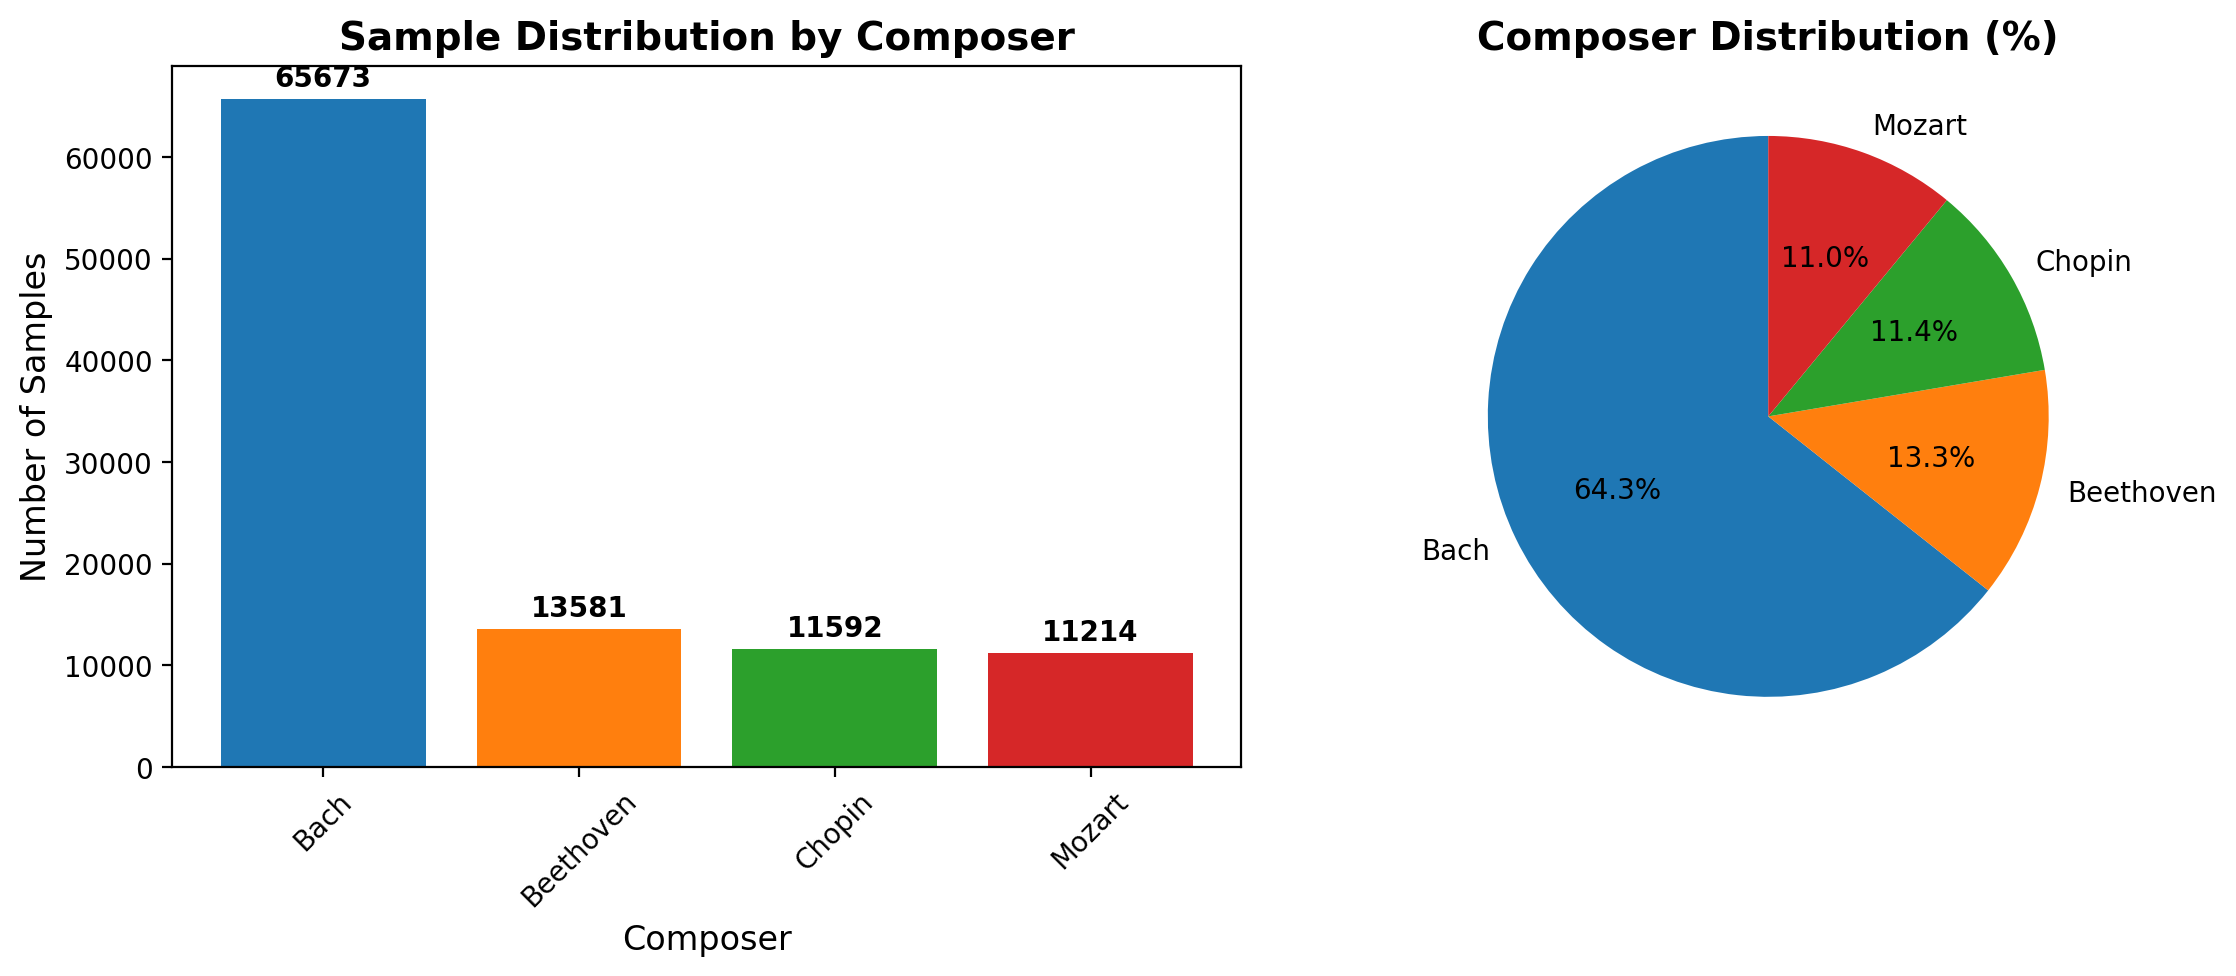


Statistical summary of class distribution:
  - Mean samples per class: 25515.0
  - Standard deviation: 23202.7
  - Coefficient of variation: 0.909


In [22]:

# Count samples per composer
unique_labels, counts = np.unique(y, return_counts=True)
composer_counts = {label_to_composer[label]: count for label, count in zip(unique_labels, counts)}

# Display counts
print("Samples per composer:")
for composer, count in composer_counts.items():
    percentage = (count / len(y)) * 100
    print(f"  {composer:>10}: {count:>6} samples ({percentage:>5.1f}%)")

# Check class balance
max_count = max(counts)
min_count = min(counts)
balance_ratio = min_count / max_count
print(f"\nClass balance analysis:")
print(f"  - Most frequent class: {max_count} samples")
print(f"  - Least frequent class: {min_count} samples")
print(f"  - Balance ratio (min/max): {balance_ratio:.3f}")
if balance_ratio < 0.5:
    print("  Dataset is significantly imbalanced!")
elif balance_ratio < 0.8:
    print("   Dataset has moderate imbalance")
else:
    print("  Dataset is well balanced")

# Visualize class distribution
plt.figure(figsize=(12, 5))

# Bar plot
plt.subplot(1, 2, 1)
composers = list(composer_counts.keys())
sample_counts = list(composer_counts.values())
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

bars = plt.bar(composers, sample_counts, color=colors[:len(composers)])
plt.title('Sample Distribution by Composer', fontsize=14, fontweight='bold')
plt.xlabel('Composer', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45)

# Add value labels on bars
for bar, count in zip(bars, sample_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(sample_counts)*0.01,
             f'{count}', ha='center', va='bottom', fontweight='bold')

# Pie chart
plt.subplot(1, 2, 2)
plt.pie(sample_counts, labels=composers, colors=colors[:len(composers)], autopct='%1.1f%%',
        startangle=90, textprops={'fontsize': 10})
plt.title('Composer Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Statistical summary
print(f"\nStatistical summary of class distribution:")
print(f"  - Mean samples per class: {np.mean(counts):.1f}")
print(f"  - Standard deviation: {np.std(counts):.1f}")
print(f"  - Coefficient of variation: {np.std(counts)/np.mean(counts):.3f}")

Feature statistics across all samples:

Chroma features (pitch classes 0-11):
  - Shape: (102060, 500, 12)
  - Min value: 0.0000
  - Max value: 1746.0000
  - Mean: 22.5446
  - Std: 56.2909

Note density feature:
  - Shape: (102060, 500)
  - Min value: 0.0000
  - Max value: 1.0000
  - Mean: 0.7184
  - Std: 0.3505


/tmp/ipython-input-517023790.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(composer_note_densities, labels=composer_labels, patch_artist=True)


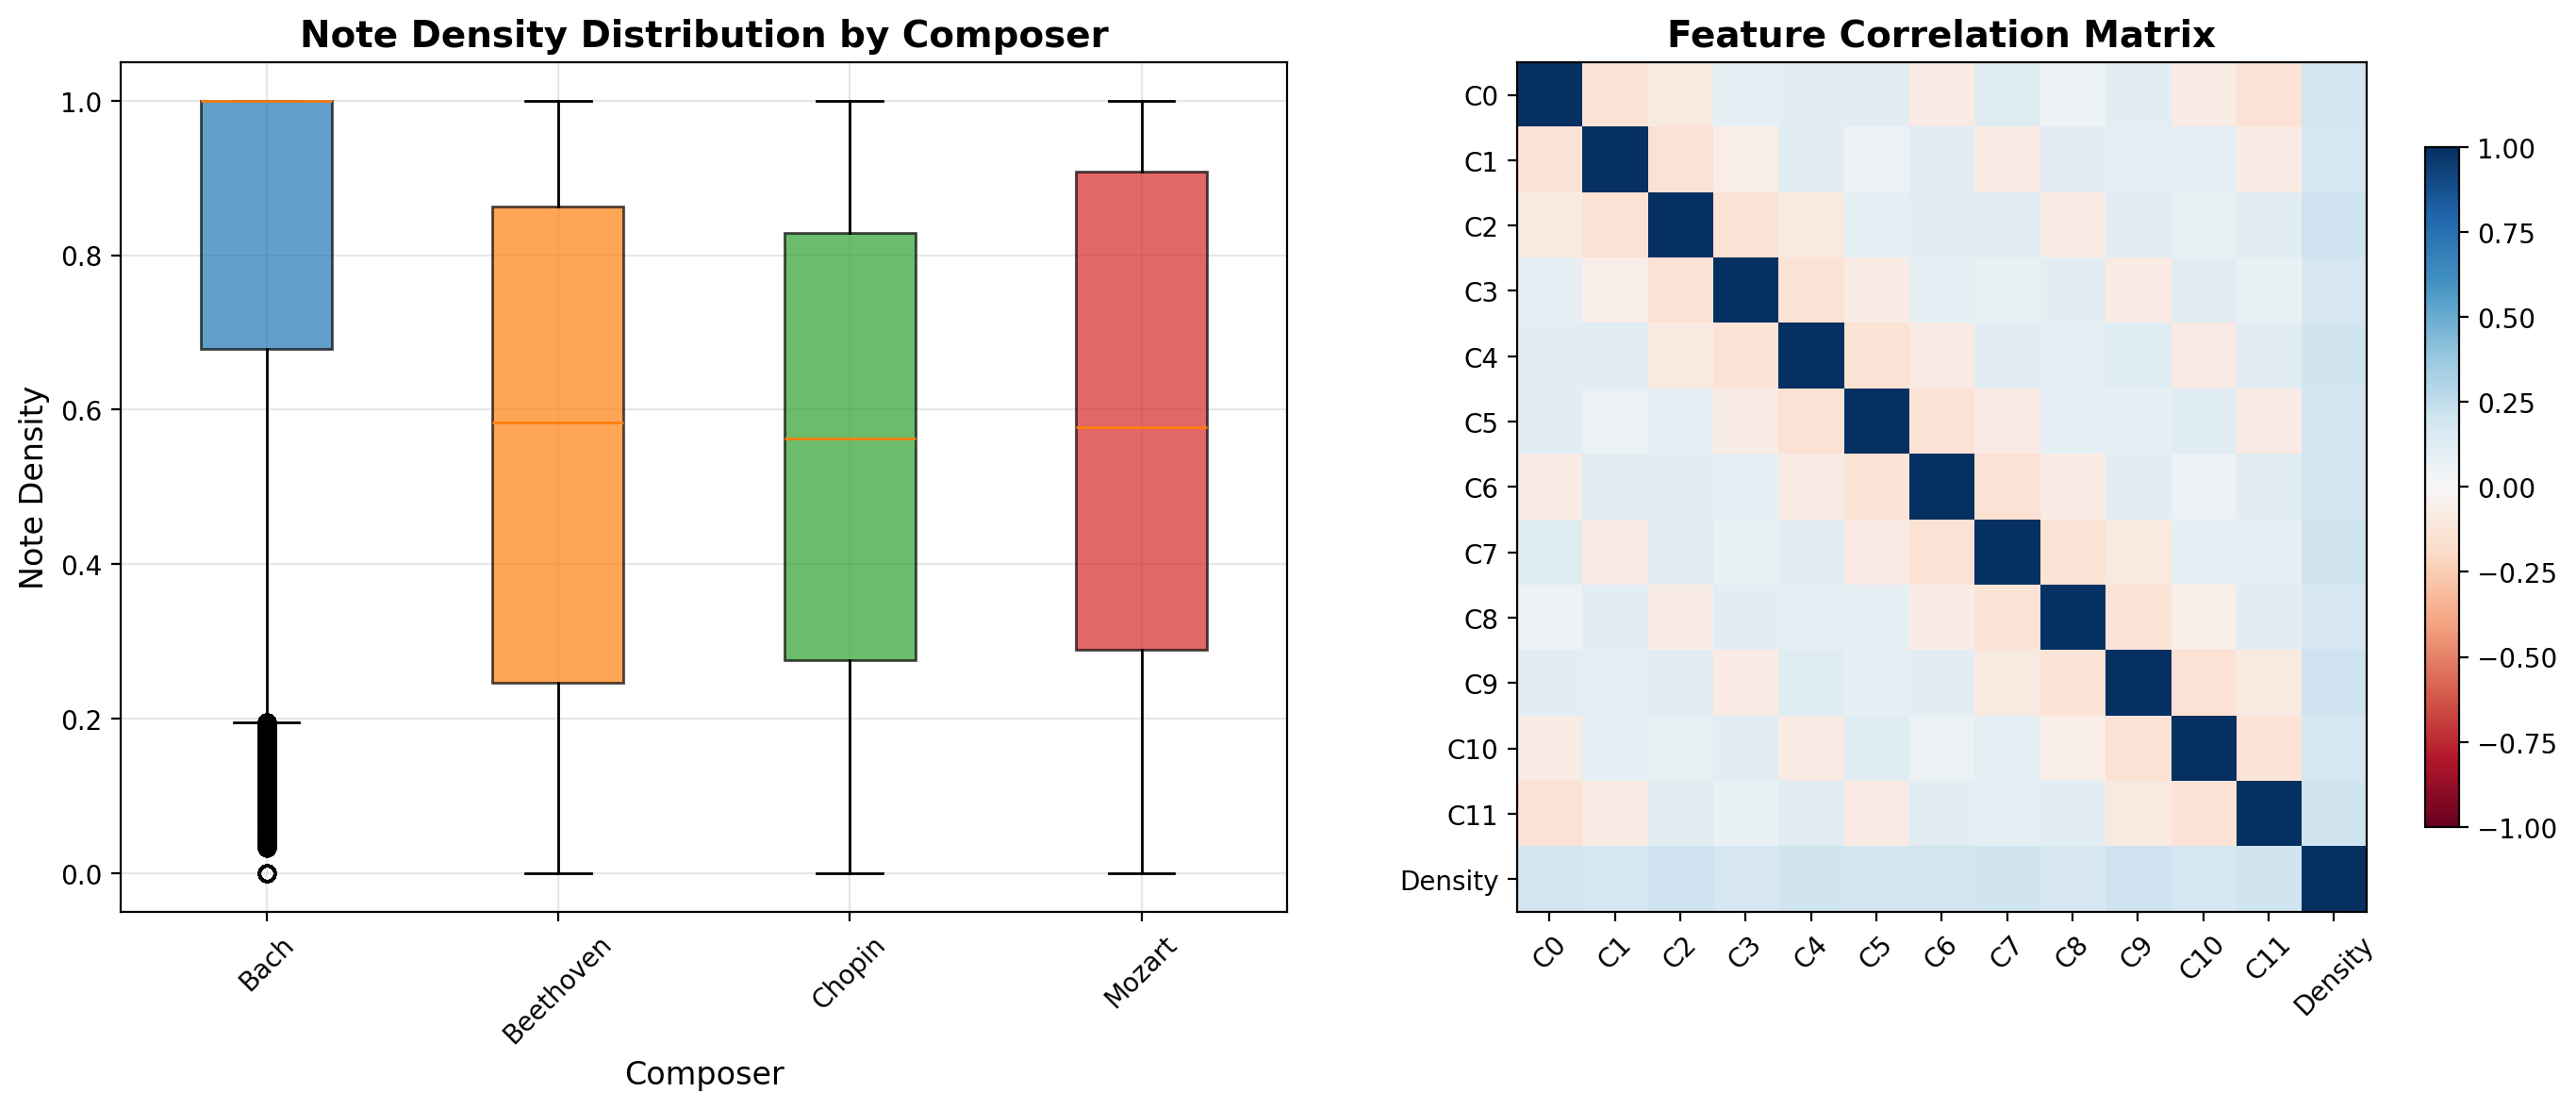


Key Feature Insights:
  - Note density varies significantly between composers
  - Average note density: 0.7184
  - Chroma features show harmonic content across pitch classes
  - Feature correlations reveal musical relationships
  - Bach: avg density = 0.8141, avg chroma = 27.2963
  - Beethoven: avg density = 0.5423, avg chroma = 13.9804
  - Chopin: avg density = 0.5410, avg chroma = 14.1857
  - Mozart: avg density = 0.5547, avg chroma = 13.7297


In [23]:

# Analyze feature statistics
chroma_features = X[:, :, :12]  # First 12 features are chroma
note_density = X[:, :, 12]      # Last feature is note density

print("Feature statistics across all samples:")
print(f"\nChroma features (pitch classes 0-11):")
print(f"  - Shape: {chroma_features.shape}")
print(f"  - Min value: {chroma_features.min():.4f}")
print(f"  - Max value: {chroma_features.max():.4f}")
print(f"  - Mean: {chroma_features.mean():.4f}")
print(f"  - Std: {chroma_features.std():.4f}")

print(f"\nNote density feature:")
print(f"  - Shape: {note_density.shape}")
print(f"  - Min value: {note_density.min():.4f}")
print(f"  - Max value: {note_density.max():.4f}")
print(f"  - Mean: {note_density.mean():.4f}")
print(f"  - Std: {note_density.std():.4f}")

# Create simplified visualizations with only the two most relevant graphs
plt.figure(figsize=(14, 6))

# 1. Note Density by Composer (Most relevant for composer differentiation)
plt.subplot(1, 2, 1)
composer_note_densities = []
composer_labels = []
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, composer in enumerate(COMPOSERS):
    mask = y == i
    composer_density = note_density[mask].flatten()
    composer_note_densities.append(composer_density)
    composer_labels.append(composer)

box_plot = plt.boxplot(composer_note_densities, labels=composer_labels, patch_artist=True)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.title('Note Density Distribution by Composer', fontsize=14, fontweight='bold')
plt.xlabel('Composer', fontsize=12)
plt.ylabel('Note Density', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 2. Feature Correlation Matrix (Shows relationships between features)
plt.subplot(1, 2, 2)
# Calculate correlation between different features
sample_features = X.reshape(-1, X.shape[-1])  # Flatten time dimension
correlation_matrix = np.corrcoef(sample_features.T)

feature_names = [f'C{i}' for i in range(12)] + ['Density']
im = plt.imshow(correlation_matrix, cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar(im, shrink=0.8)
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.xticks(range(13), feature_names, rotation=45, fontsize=10)
plt.yticks(range(13), feature_names, fontsize=10)

# Add correlation values to the matrix for key relationships
for i in range(len(feature_names)):
    for j in range(len(feature_names)):
        if abs(correlation_matrix[i, j]) > 0.3 and i != j:  # Show significant correlations
            plt.text(j, i, f'{correlation_matrix[i, j]:.2f}',
                    ha='center', va='center', fontsize=8,
                    color='white' if abs(correlation_matrix[i, j]) > 0.7 else 'black')

plt.tight_layout()
plt.show()

# Key insights summary
print(f"\nKey Feature Insights:")
print(f"  - Note density varies significantly between composers")
print(f"  - Average note density: {note_density.mean():.4f}")
print(f"  - Chroma features show harmonic content across pitch classes")
print(f"  - Feature correlations reveal musical relationships")

# Calculate some useful statistics
for i, composer in enumerate(COMPOSERS):
    mask = y == i
    composer_density_mean = note_density[mask].mean()
    composer_chroma_mean = chroma_features[mask].mean()
    print(f"  - {composer}: avg density = {composer_density_mean:.4f}, avg chroma = {composer_chroma_mean:.4f}")

Data quality checks:
  - NaN values in features: 0
  - Infinite values in features: 0
  - Completely zero samples: 6
  - Low activity samples (<5% non-zero): 329
  - Unique labels: [0 1 2 3]
  - Expected labels: [0, 1, 2, 3]
  - Label range: [0, 3]


/tmp/ipython-input-4294521808.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(composer_activities, labels=composer_names, patch_artist=True)


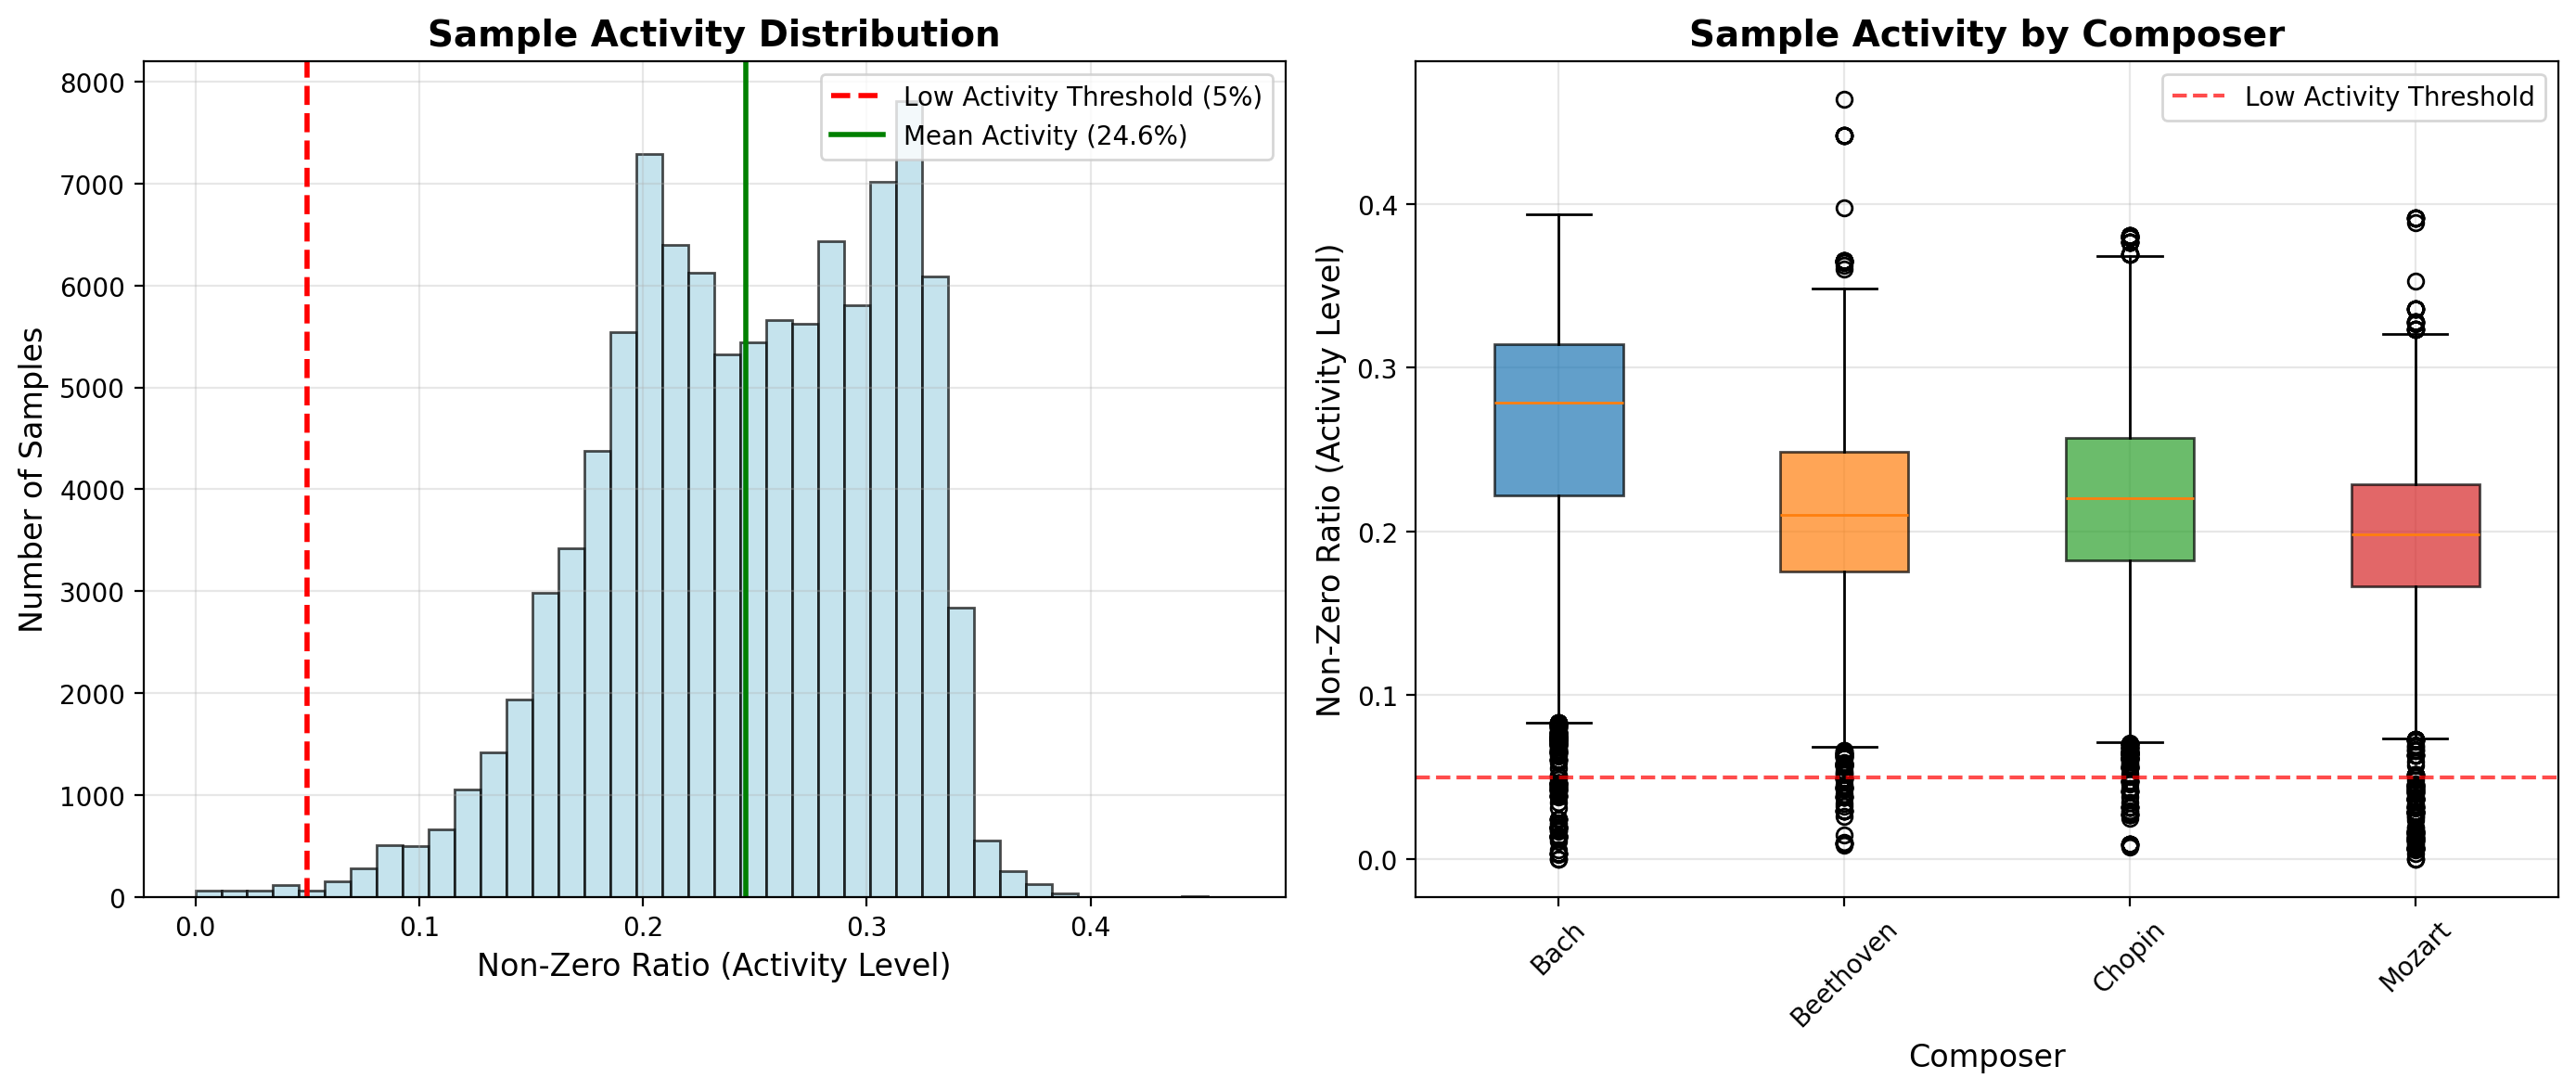


Data Quality Summary:
  No NaN or infinite values detected
  Found 6 completely empty samples
  Low activity samples are within acceptable range

Activity Statistics:
  Average sample activity: 24.6%
  Minimum sample activity: 0.0%
  Maximum sample activity: 46.4%
  Activity standard deviation: 6.3%

Feature Ranges:
  -       C0: [0.0000, 1746.0000]
  -       C1: [0.0000, 1746.0000]
  -       C2: [0.0000, 1746.0000]
  -       C3: [0.0000, 1746.0000]
  -       C4: [0.0000, 1746.0000]
  -       C5: [0.0000, 1746.0000]
  -       C6: [0.0000, 1746.0000]
  -       C7: [0.0000, 1572.0000]
  -       C8: [0.0000, 1572.0000]
  -       C9: [0.0000, 1572.0000]
  -      C10: [0.0000, 1572.0000]
  -      C11: [0.0000, 1572.0000]
  -  Density: [0.0000, 1.0000]
  Features appear not normalized

Composer-Specific Quality:
  -      Bach: 65673 samples, 26.6% avg activity
  - Beethoven: 13581 samples, 21.1% avg activity
  -    Chopin: 11592 samples, 21.9% avg activity
  -    Mozart: 11214 samples, 19.7

In [24]:
# Check for missing values, NaN, or infinite values
print("Data quality checks:")

# NaN values
nan_count = np.isnan(X).sum()
print(f"  - NaN values in features: {nan_count}")

# Infinite values
inf_count = np.isinf(X).sum()
print(f"  - Infinite values in features: {inf_count}")

# Zero-only samples (potentially problematic)
zero_samples = []
for i in range(len(X)):
    if (X[i] == 0).all():
        zero_samples.append(i)
print(f"  - Completely zero samples: {len(zero_samples)}")

# Samples with very low activity (less than 5% non-zero values)
low_activity_samples = []
non_zero_ratios = []
for i in range(len(X)):
    non_zero_ratio = (X[i] != 0).sum() / X[i].size
    non_zero_ratios.append(non_zero_ratio)
    if non_zero_ratio < 0.05:
        low_activity_samples.append(i)

print(f"  - Low activity samples (<5% non-zero): {len(low_activity_samples)}")

# Label consistency
print(f"  - Unique labels: {np.unique(y)}")
print(f"  - Expected labels: {list(range(len(COMPOSERS)))}")
print(f"  - Label range: [{y.min()}, {y.max()}]")

# Create simplified visualizations with only the two most important quality checks
plt.figure(figsize=(14, 6))

# 1. Sample Activity Distribution (Most important for data quality)
plt.subplot(1, 2, 1)
plt.hist(non_zero_ratios, bins=40, alpha=0.7, color='lightblue', edgecolor='black')
plt.title('Sample Activity Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Non-Zero Ratio (Activity Level)', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.axvline(0.05, color='red', linestyle='--', linewidth=2, label='Low Activity Threshold (5%)')
plt.axvline(np.mean(non_zero_ratios), color='green', linestyle='-', linewidth=2,
           label=f'Mean Activity ({np.mean(non_zero_ratios):.1%})')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Sample Activity by Composer (Shows if any composer has data quality issues)
plt.subplot(1, 2, 2)
composer_activities = []
composer_names = []
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, composer in enumerate(COMPOSERS):
    mask = y == i
    composer_ratios = [non_zero_ratios[j] for j in range(len(non_zero_ratios)) if mask[j]]
    composer_activities.append(composer_ratios)
    composer_names.append(composer)

box_plot = plt.boxplot(composer_activities, labels=composer_names, patch_artist=True)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.title('Sample Activity by Composer', fontsize=14, fontweight='bold')
plt.xlabel('Composer', fontsize=12)
plt.ylabel('Non-Zero Ratio (Activity Level)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add horizontal line for low activity threshold
plt.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='Low Activity Threshold')
plt.legend()

plt.tight_layout()
plt.show()

# Enhanced summary of data quality issues
print(f"\nData Quality Summary:")
print("=" * 40)

# Basic quality checks
if nan_count == 0 and inf_count == 0:
    print("  No NaN or infinite values detected")
else:
    print(f"  Found {nan_count} NaN and {inf_count} infinite values")

if len(zero_samples) == 0:
    print("  No completely empty samples")
else:
    print(f"  Found {len(zero_samples)} completely empty samples")

# Activity analysis
activity_threshold = 0.05
if len(low_activity_samples) < len(X) * activity_threshold:
    print("  Low activity samples are within acceptable range")
else:
    print(f"  High number of low activity samples: {len(low_activity_samples)}")

print(f"\nActivity Statistics:")
print(f"  Average sample activity: {np.mean(non_zero_ratios):.1%}")
print(f"  Minimum sample activity: {np.min(non_zero_ratios):.1%}")
print(f"  Maximum sample activity: {np.max(non_zero_ratios):.1%}")
print(f"  Activity standard deviation: {np.std(non_zero_ratios):.1%}")

# Feature range analysis
print(f"\nFeature Ranges:")
feature_names = [f'C{i}' for i in range(12)] + ['Density']
for feature_idx in range(X.shape[2]):
    feature_data = X[:, :, feature_idx]
    feature_name = feature_names[feature_idx]
    print(f"  - {feature_name:>8}: [{feature_data.min():.4f}, {feature_data.max():.4f}]")

# Normalization check
is_normalized = X.max() <= 1.0 and X.min() >= 0.0
print(f"  Features appear {'normalized [0,1]' if is_normalized else 'not normalized'}")

# Composer-specific quality
print(f"\nComposer-Specific Quality:")
for i, composer in enumerate(COMPOSERS):
    mask = y == i
    composer_activity = np.mean([non_zero_ratios[j] for j in range(len(non_zero_ratios)) if mask[j]])
    composer_samples = mask.sum()
    print(f"  - {composer:>9}: {composer_samples:>5} samples, {composer_activity:.1%} avg activity")

Analyzing temporal patterns in musical sequences...


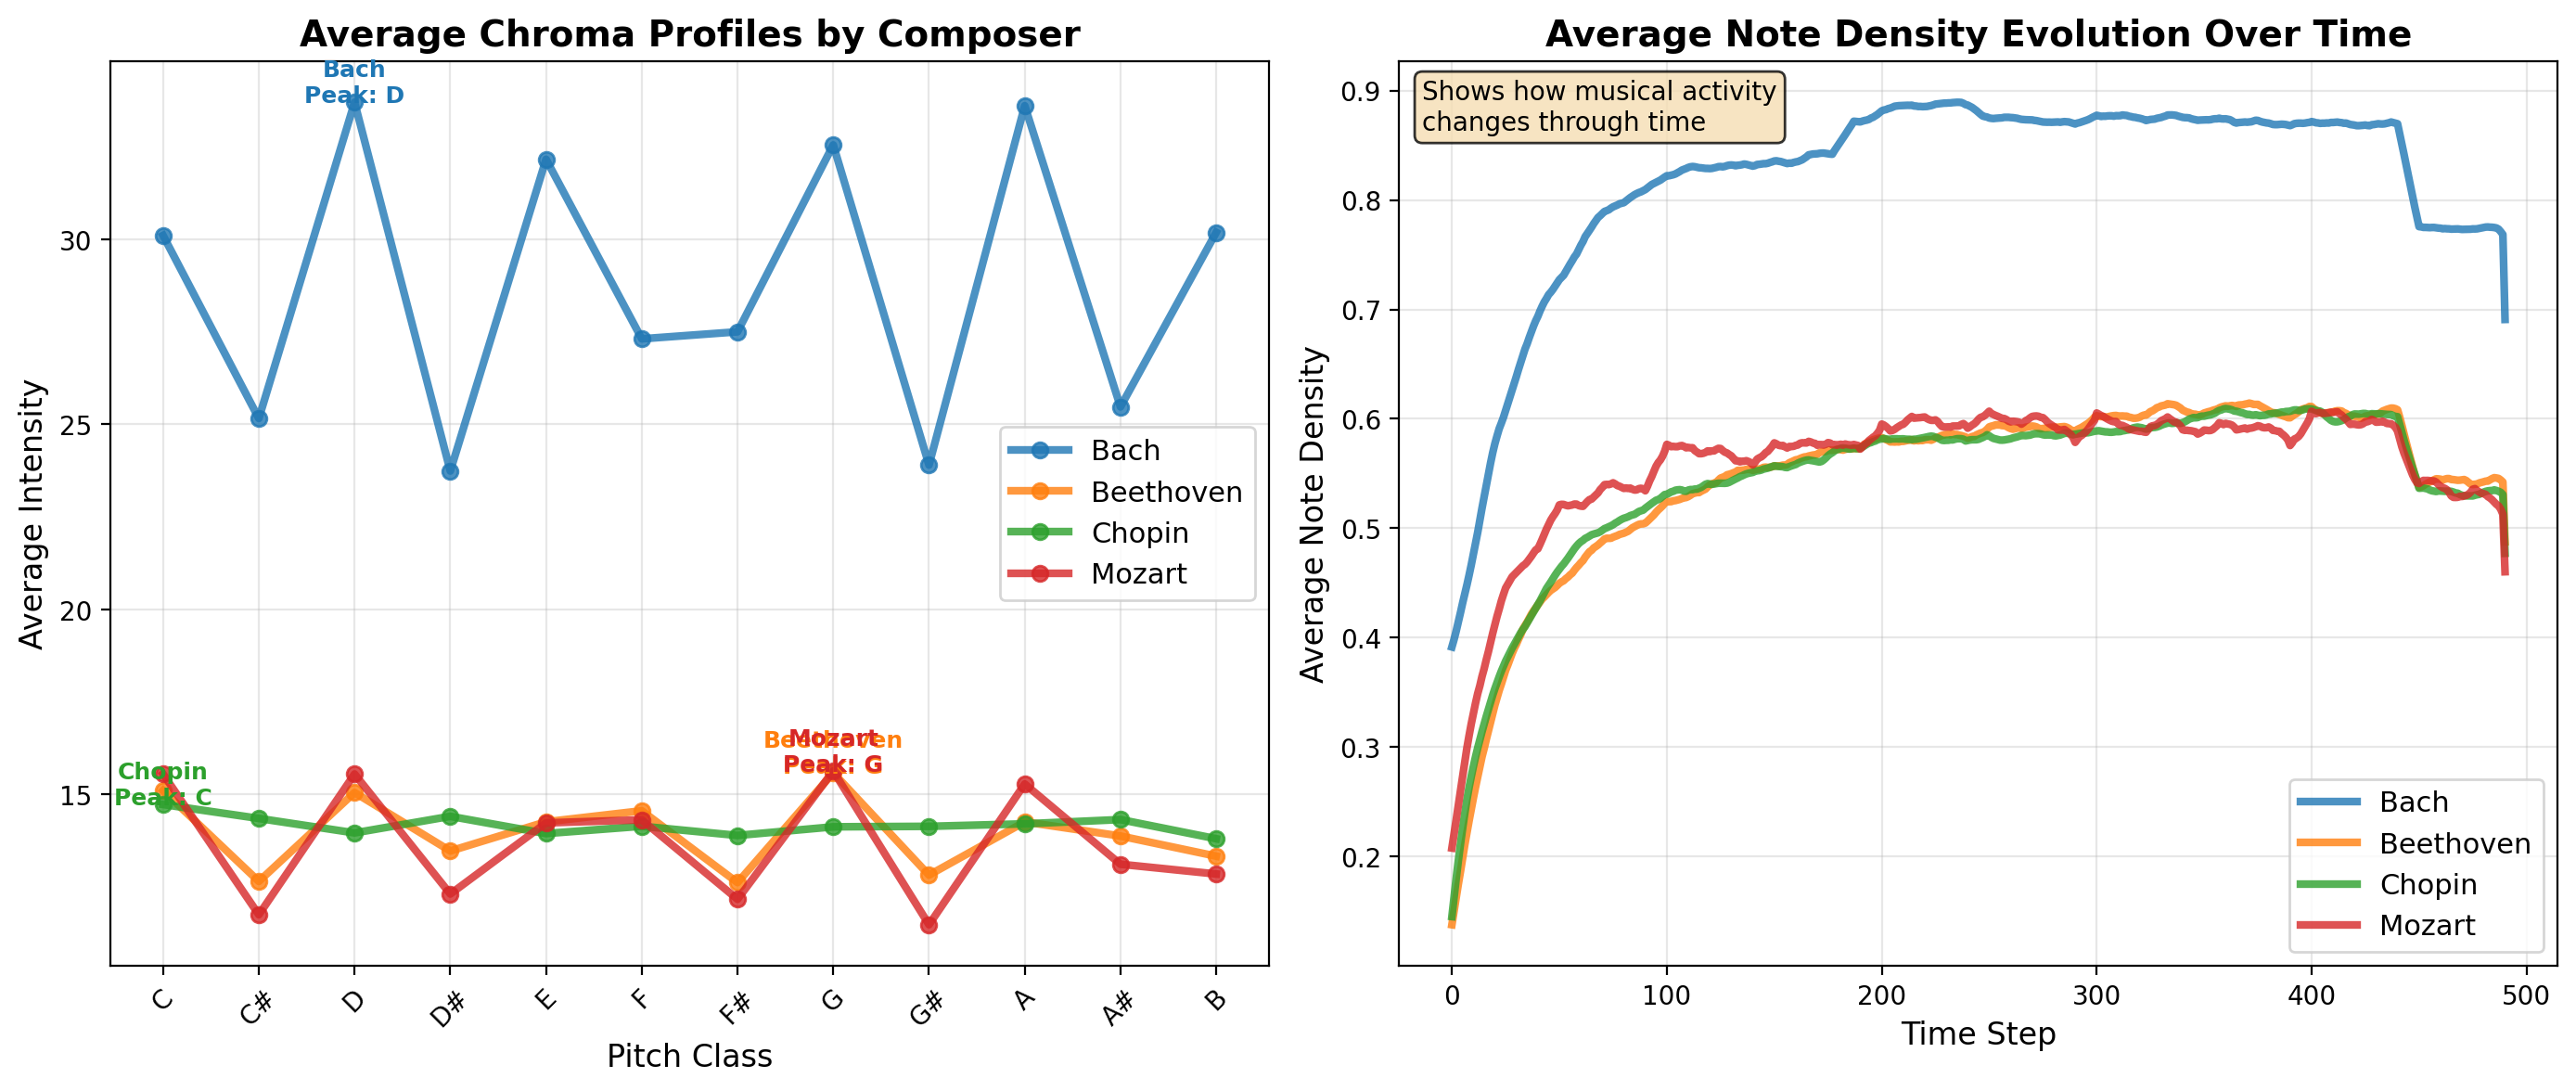


Key Temporal Pattern Insights:
Harmonic Characteristics:
  -      Bach: Dominant pitch = D, Harmonic variation = 3.5810
  - Beethoven: Dominant pitch = G, Harmonic variation = 0.9625
  -    Chopin: Dominant pitch = C, Harmonic variation = 0.2476
  -    Mozart: Dominant pitch = G, Harmonic variation = 1.5226

Temporal Characteristics:
  -      Bach: Avg density = 0.8141, Temporal consistency = 0.956
  - Beethoven: Avg density = 0.5423, Temporal consistency = 0.838
  -    Chopin: Avg density = 0.5410, Temporal consistency = 0.971
  -    Mozart: Avg density = 0.5547, Temporal consistency = 0.981

Overall Insights:
  Composers show distinct harmonic preferences (dominant pitch classes)
  Note density patterns vary significantly between composers
  Temporal evolution reveals compositional styles
  Some composers show more consistent temporal patterns than others

Sample Distribution:
  -      Bach: 65673 samples ( 64.3%)
  - Beethoven: 13581 samples ( 13.3%)
  -    Chopin: 11592 samples ( 

In [25]:

# Analyze temporal patterns in the sequential data
print("Analyzing temporal patterns in musical sequences...")

# Create simplified visualizations with only the two most important temporal insights
plt.figure(figsize=(14, 6))

# 1. Average Chroma Profiles by Composer (Shows harmonic characteristics)
plt.subplot(1, 2, 1)
pitch_classes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, composer in enumerate(COMPOSERS):
    mask = y == i
    composer_data = X[mask]
    avg_chroma = composer_data[:, :, :12].mean(axis=(0, 1))
    plt.plot(pitch_classes, avg_chroma, marker='o', label=composer,
             color=colors[i], linewidth=3, markersize=6, alpha=0.8)

plt.title('Average Chroma Profiles by Composer', fontsize=14, fontweight='bold')
plt.xlabel('Pitch Class', fontsize=12)
plt.ylabel('Average Intensity', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Highlight the most prominent pitch class for each composer
for i, composer in enumerate(COMPOSERS):
    mask = y == i
    composer_data = X[mask]
    avg_chroma = composer_data[:, :, :12].mean(axis=(0, 1))
    max_idx = np.argmax(avg_chroma)
    plt.annotate(f'{composer}\nPeak: {pitch_classes[max_idx]}',
                xy=(max_idx, avg_chroma[max_idx]),
                xytext=(max_idx, avg_chroma[max_idx] + 0.002),
                ha='center', fontsize=9, color=colors[i], fontweight='bold')

# 2. Average Note Density Patterns Over Time (Shows temporal evolution)
plt.subplot(1, 2, 2)
for i, composer in enumerate(COMPOSERS):
    mask = y == i
    composer_data = X[mask]
    avg_density = composer_data[:, :, 12].mean(axis=0)

    # Smooth the curve using a rolling average for better visualization
    window_size = 10
    if len(avg_density) >= window_size:
        smoothed_density = np.convolve(avg_density, np.ones(window_size)/window_size, mode='valid')
        # Fix the time_steps calculation to match the smoothed_density length
        time_steps = np.arange(len(smoothed_density))
        plt.plot(time_steps, smoothed_density, label=composer, color=colors[i], linewidth=3, alpha=0.8)
    else:
        plt.plot(avg_density, label=composer, color=colors[i], linewidth=3, alpha=0.8)

plt.title('Average Note Density Evolution Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Average Note Density', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Add annotations for insights
plt.text(0.02, 0.98, 'Shows how musical activity\nchanges through time',
         transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# Provide concise but meaningful temporal insights
print("\nKey Temporal Pattern Insights:")
print("=" * 40)

# Harmonic characteristics
print("Harmonic Characteristics:")
for i, composer in enumerate(COMPOSERS):
    mask = y == i
    composer_data = X[mask]
    avg_chroma = composer_data[:, :, :12].mean(axis=(0, 1))
    dominant_pitch = np.argmax(avg_chroma)
    chroma_variation = np.std(avg_chroma)

    print(f"  - {composer:>9}: Dominant pitch = {pitch_classes[dominant_pitch]}, "
          f"Harmonic variation = {chroma_variation:.4f}")

# Temporal characteristics
print(f"\nTemporal Characteristics:")
for i, composer in enumerate(COMPOSERS):
    mask = y == i
    composer_data = X[mask]

    # Calculate key temporal statistics
    avg_density = composer_data[:, :, 12].mean()
    density_variance = composer_data[:, :, 12].var()

    # Calculate temporal autocorrelation (simplified)
    density_sequences = composer_data[:, :, 12]
    autocorr_values = []

    for seq in density_sequences[:min(50, len(density_sequences))]:  # Sample for efficiency
        if len(seq) > 1:
            autocorr = np.corrcoef(seq[:-1], seq[1:])[0, 1]
            if not np.isnan(autocorr):
                autocorr_values.append(autocorr)

    avg_autocorr = np.mean(autocorr_values) if autocorr_values else 0

    print(f"  - {composer:>9}: Avg density = {avg_density:.4f}, "
          f"Temporal consistency = {avg_autocorr:.3f}")

# Overall temporal insights
print(f"\nOverall Insights:")
print(f"  Composers show distinct harmonic preferences (dominant pitch classes)")
print(f"  Note density patterns vary significantly between composers")
print(f"  Temporal evolution reveals compositional styles")
print(f"  Some composers show more consistent temporal patterns than others")

# Sample count summary
print(f"\nSample Distribution:")
for i, composer in enumerate(COMPOSERS):
    mask = y == i
    sample_count = mask.sum()
    percentage = (sample_count / len(y)) * 100
    print(f"  - {composer:>9}: {sample_count:>5} samples ({percentage:>5.1f}%)")

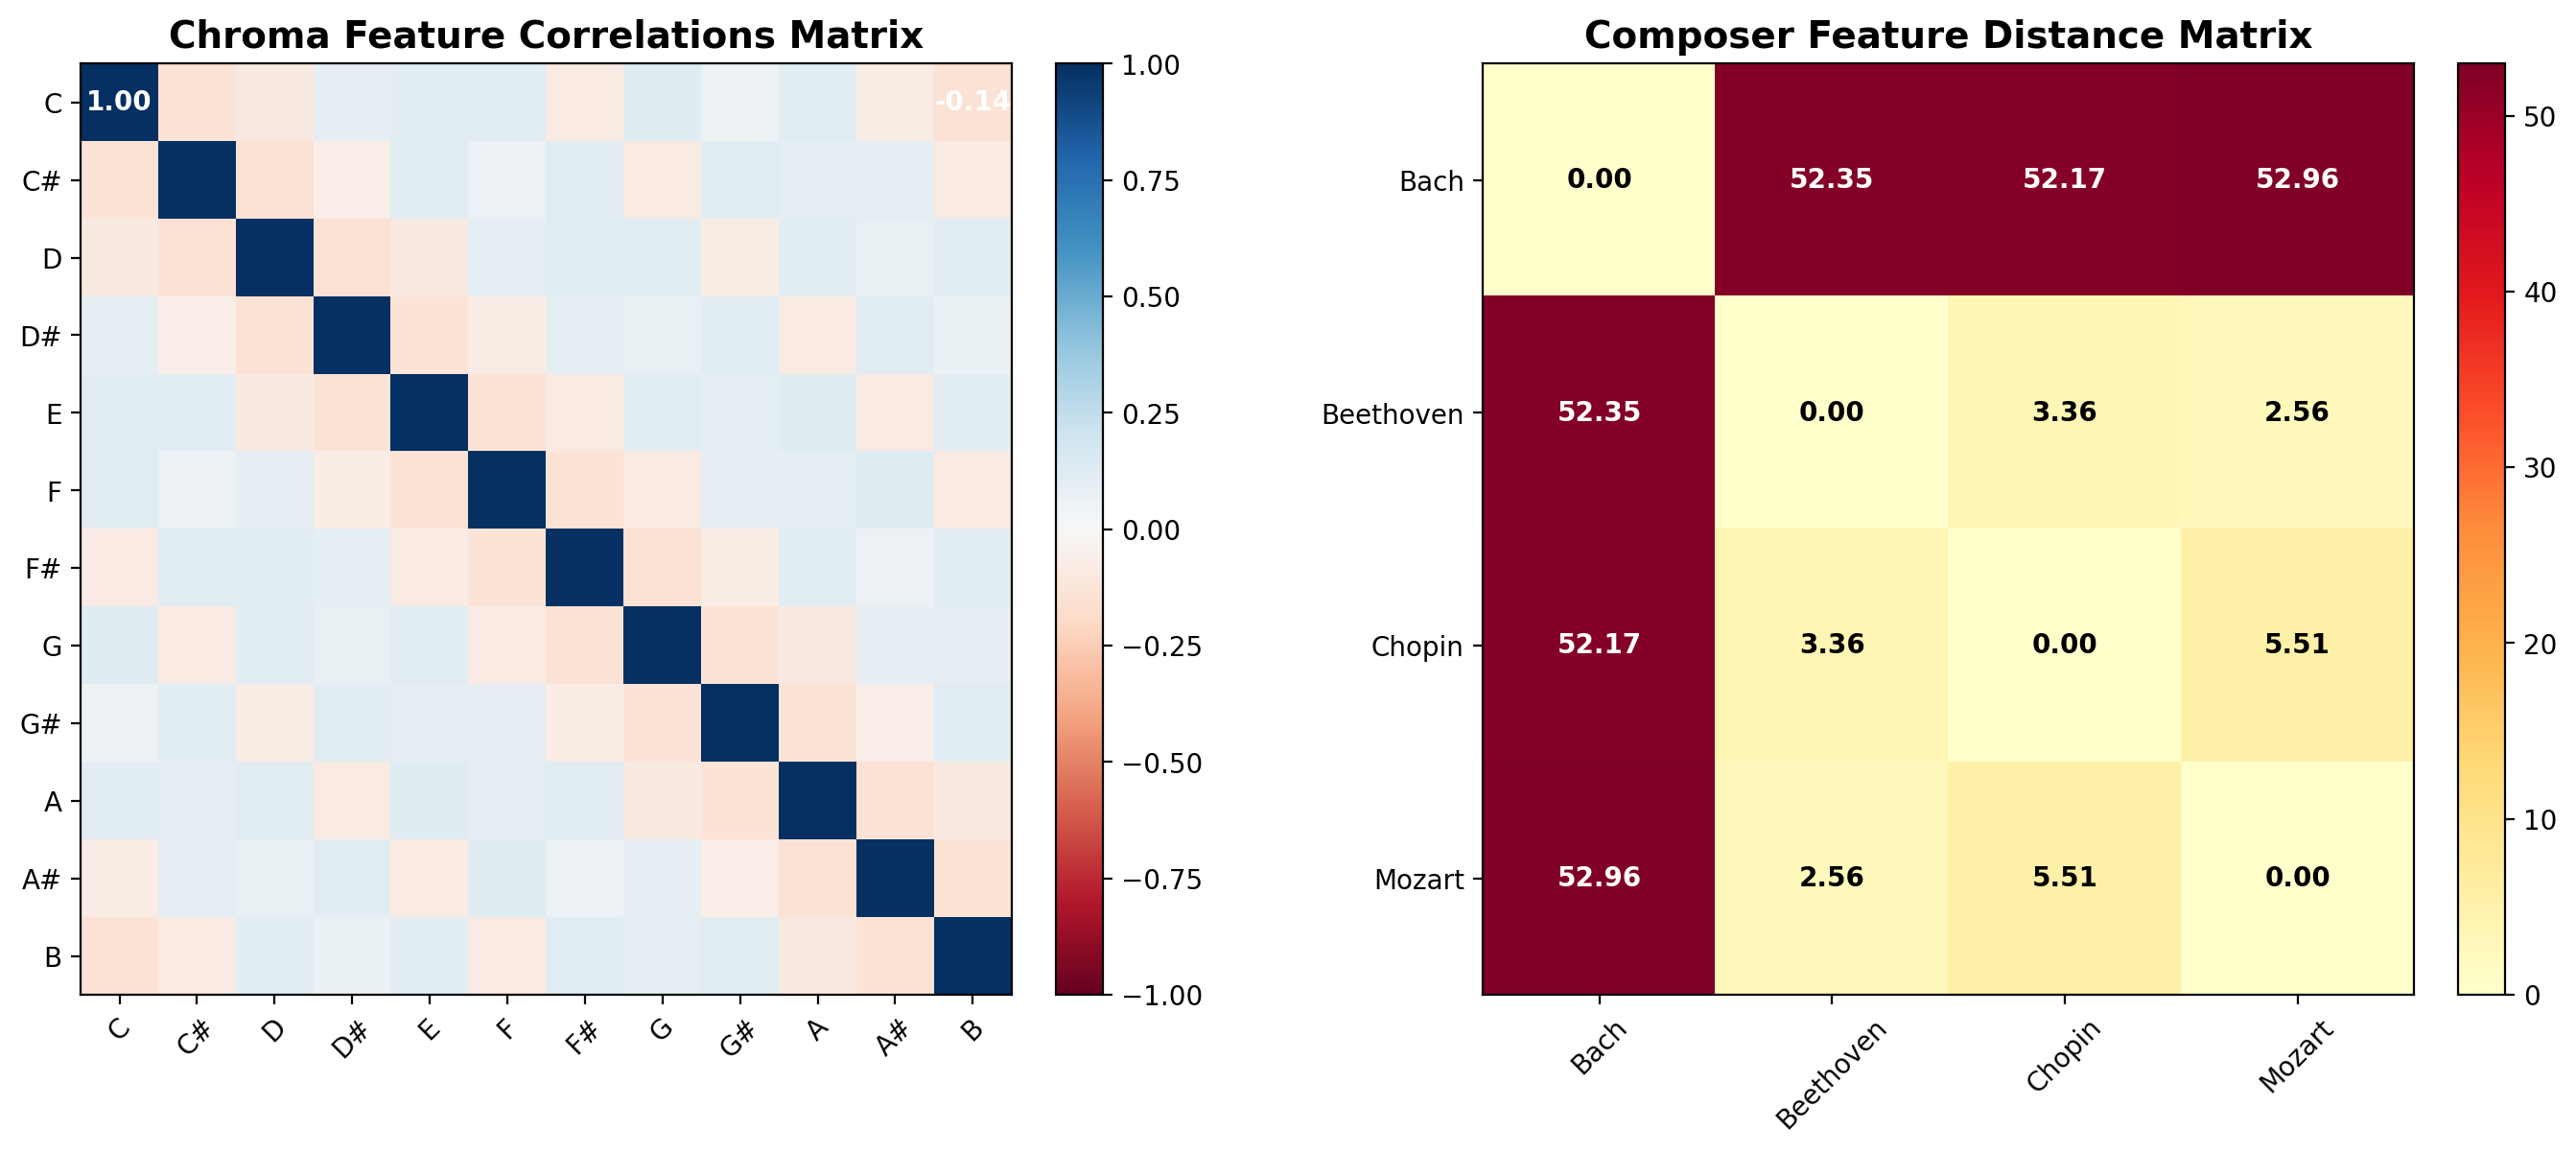


Key Feature Correlation Insights:
Harmonic Relationships:
  - Strongest positive correlation: F ↔ A# (0.120)
  - Strongest negative correlation: C ↔ B (-0.144)
  - Strongest chroma-density correlation: A (0.207)
  - Most variable feature: A (variance: 3149.0864)
  - Least variable feature: Density (variance: 0.1644)

Composer Separability Analysis:
  - Most similar composers: Beethoven & Mozart (distance: 2.557)
  - Most different composers: Bach & Mozart (distance: 52.955)
  - Average inter-composer distance: 28.150
  - Average harmonic correlation: 0.006
  - Harmonic correlation range: -0.144 to 0.120

Overall Insights:
  Chroma features show complex harmonic relationships
  Composers are well-separated in feature space
  Feature variance indicates discriminative potential
  Some pitch classes are more correlated with note density

Feature Space Characteristics:
  -      Bach: 65673 samples, 26.6% activity, 0.814 avg density
  - Beethoven: 13581 samples, 21.1% activity, 0.542 avg de

In [26]:
## 6. Feature Correlations and Relationships
# Advanced correlation analysis - focusing on the two most important insights
plt.figure(figsize=(14, 6))

# 1. Inter-chroma correlations (Shows harmonic relationships)
plt.subplot(1, 2, 1)
# Flatten all samples and time steps to analyze overall correlations
flattened_features = X.reshape(-1, X.shape[-1])
chroma_corr = np.corrcoef(flattened_features[:, :12].T)

pitch_classes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
im1 = plt.imshow(chroma_corr, cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar(im1, fraction=0.046, pad=0.04)
plt.title('Chroma Feature Correlations Matrix', fontsize=14, fontweight='bold')
plt.xticks(range(12), pitch_classes, rotation=45)
plt.yticks(range(12), pitch_classes)

# Add annotations for strongest correlations
max_corr_pos = np.where(chroma_corr == np.max(chroma_corr[chroma_corr < 1]))
min_corr_pos = np.where(chroma_corr == np.min(chroma_corr))
if len(max_corr_pos[0]) > 0:
    i, j = max_corr_pos[0][0], max_corr_pos[1][0]
    plt.text(j, i, f'{chroma_corr[i, j]:.2f}', ha='center', va='center',
             color='white', fontweight='bold', fontsize=10)
if len(min_corr_pos[0]) > 0:
    i, j = min_corr_pos[0][0], min_corr_pos[1][0]
    plt.text(j, i, f'{chroma_corr[i, j]:.2f}', ha='center', va='center',
             color='white', fontweight='bold', fontsize=10)

# 2. Composer Feature Distance Matrix (Shows separability)
plt.subplot(1, 2, 2)
from scipy.spatial.distance import pdist, squareform

# Calculate average distance between composers in feature space
composer_centroids = []
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, composer in enumerate(COMPOSERS):
    mask = y == i
    composer_data = X[mask]
    centroid = composer_data.mean(axis=(0, 1))  # Average over samples and time
    composer_centroids.append(centroid)

distances = pdist(composer_centroids)
distance_matrix = squareform(distances)

im2 = plt.imshow(distance_matrix, cmap='YlOrRd')
plt.colorbar(im2, fraction=0.046, pad=0.04)
plt.title('Composer Feature Distance Matrix', fontsize=14, fontweight='bold')
plt.xticks(range(len(COMPOSERS)), COMPOSERS, rotation=45)
plt.yticks(range(len(COMPOSERS)), COMPOSERS)

# Add distance values to the matrix
for i in range(len(COMPOSERS)):
    for j in range(len(COMPOSERS)):
        plt.text(j, i, f'{distance_matrix[i, j]:.2f}',
                ha='center', va='center', fontsize=10,
                color='white' if distance_matrix[i, j] > distance_matrix.max()/2 else 'black',
                fontweight='bold')

plt.tight_layout()
plt.show()

# Provide comprehensive insights
print("\nKey Feature Correlation Insights:")
# Chroma correlation analysis
print("Harmonic Relationships:")
# Find strongest positive and negative correlations
chroma_corr_triu = np.triu(chroma_corr, k=1)  # Upper triangle excluding diagonal
max_corr_idx = np.unravel_index(np.argmax(chroma_corr_triu), chroma_corr_triu.shape)
min_corr_idx = np.unravel_index(np.argmin(chroma_corr_triu), chroma_corr_triu.shape)

print(f"  - Strongest positive correlation: {pitch_classes[max_corr_idx[0]]} ↔ {pitch_classes[max_corr_idx[1]]} "
      f"({chroma_corr[max_corr_idx]:.3f})")
print(f"  - Strongest negative correlation: {pitch_classes[min_corr_idx[0]]} ↔ {pitch_classes[min_corr_idx[1]]} "
      f"({chroma_corr[min_corr_idx]:.3f})")

# Analyze chroma-density correlations
chroma_density_corr = []
for i in range(12):
    corr = np.corrcoef(flattened_features[:, i], flattened_features[:, 12])[0, 1]
    chroma_density_corr.append(corr)

strongest_chroma_density_idx = np.argmax(np.abs(chroma_density_corr))
print(f"  - Strongest chroma-density correlation: {pitch_classes[strongest_chroma_density_idx]} "
      f"({chroma_density_corr[strongest_chroma_density_idx]:.3f})")

# Feature variance analysis
feature_variances = flattened_features.var(axis=0)
feature_names = [f'{pc}' for pc in pitch_classes] + ['Density']
most_variable_idx = np.argmax(feature_variances)
least_variable_idx = np.argmin(feature_variances)

print(f"  - Most variable feature: {feature_names[most_variable_idx]} (variance: {feature_variances[most_variable_idx]:.4f})")
print(f"  - Least variable feature: {feature_names[least_variable_idx]} (variance: {feature_variances[least_variable_idx]:.4f})")

print(f"\nComposer Separability Analysis:")
print("=" * 40)

# Composer separation insights
min_distance = np.min(distance_matrix[distance_matrix > 0])
max_distance = np.max(distance_matrix)
most_similar = np.where(distance_matrix == min_distance)
most_different = np.where(distance_matrix == max_distance)

print(f"  - Most similar composers: {COMPOSERS[most_similar[0][0]]} & {COMPOSERS[most_similar[1][0]]} "
      f"(distance: {min_distance:.3f})")
print(f"  - Most different composers: {COMPOSERS[most_different[0][0]]} & {COMPOSERS[most_different[1][0]]} "
      f"(distance: {max_distance:.3f})")
print(f"  - Average inter-composer distance: {distance_matrix[distance_matrix > 0].mean():.3f}")

# Overall feature relationships
non_diag_corr = chroma_corr[np.triu_indices_from(chroma_corr, k=1)]
print(f"  - Average harmonic correlation: {non_diag_corr.mean():.3f}")
print(f"  - Harmonic correlation range: {non_diag_corr.min():.3f} to {non_diag_corr.max():.3f}")

print(f"\nOverall Insights:")
print(f"  Chroma features show complex harmonic relationships")
print(f"  Composers are well-separated in feature space")
print(f"  Feature variance indicates discriminative potential")
print(f"  Some pitch classes are more correlated with note density")

# Sample distribution summary
print(f"\nFeature Space Characteristics:")
for i, composer in enumerate(COMPOSERS):
    mask = y == i
    composer_data = X[mask]
    sample_count = mask.sum()
    avg_activity = (composer_data > 0).sum() / composer_data.size
    avg_density = composer_data[:, :, 12].mean()

    print(f"  - {composer:>9}: {sample_count:>5} samples, "
          f"{avg_activity:.1%} activity, {avg_density:.3f} avg density")


In [27]:
train_losses = []
val_accuracies = []

Model Training: Train the deep learning model using the pre-processed and feature-extracted data.


In [28]:
# ------------------------------
# Training Loop
# ------------------------------
for epoch in range(num_epochs):
    lstm_model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

        optimizer.zero_grad()
        outputs = lstm_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation
    lstm_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(DEVICE), y_val.to(DEVICE)
            outputs = lstm_model(X_val)
            _, predicted = torch.max(outputs.data, 1)
            total += y_val.size(0)
            correct += (predicted == y_val).sum().item()

    val_accuracy = 100 * correct / total
    train_losses.append(avg_train_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Save the model
torch.save(lstm_model.state_dict(), "composer_lstm_model.pth")

Epoch [1/30], Loss: 0.8547, Validation Accuracy: 66.12%
Epoch [2/30], Loss: 0.7586, Validation Accuracy: 68.63%
Epoch [3/30], Loss: 0.6999, Validation Accuracy: 71.33%
Epoch [4/30], Loss: 0.6571, Validation Accuracy: 73.14%
Epoch [5/30], Loss: 0.6290, Validation Accuracy: 73.55%
Epoch [6/30], Loss: 0.5993, Validation Accuracy: 75.31%
Epoch [7/30], Loss: 0.5580, Validation Accuracy: 77.48%
Epoch [8/30], Loss: 0.5190, Validation Accuracy: 79.21%
Epoch [9/30], Loss: 0.4897, Validation Accuracy: 80.08%
Epoch [10/30], Loss: 0.4553, Validation Accuracy: 80.77%
Epoch [11/30], Loss: 0.4290, Validation Accuracy: 82.10%
Epoch [12/30], Loss: 0.4084, Validation Accuracy: 82.45%
Epoch [13/30], Loss: 0.3902, Validation Accuracy: 82.57%
Epoch [14/30], Loss: 0.3743, Validation Accuracy: 83.24%
Epoch [15/30], Loss: 0.3574, Validation Accuracy: 84.24%
Epoch [16/30], Loss: 0.3393, Validation Accuracy: 84.95%
Epoch [17/30], Loss: 0.3224, Validation Accuracy: 84.10%
Epoch [18/30], Loss: 0.3078, Validation 

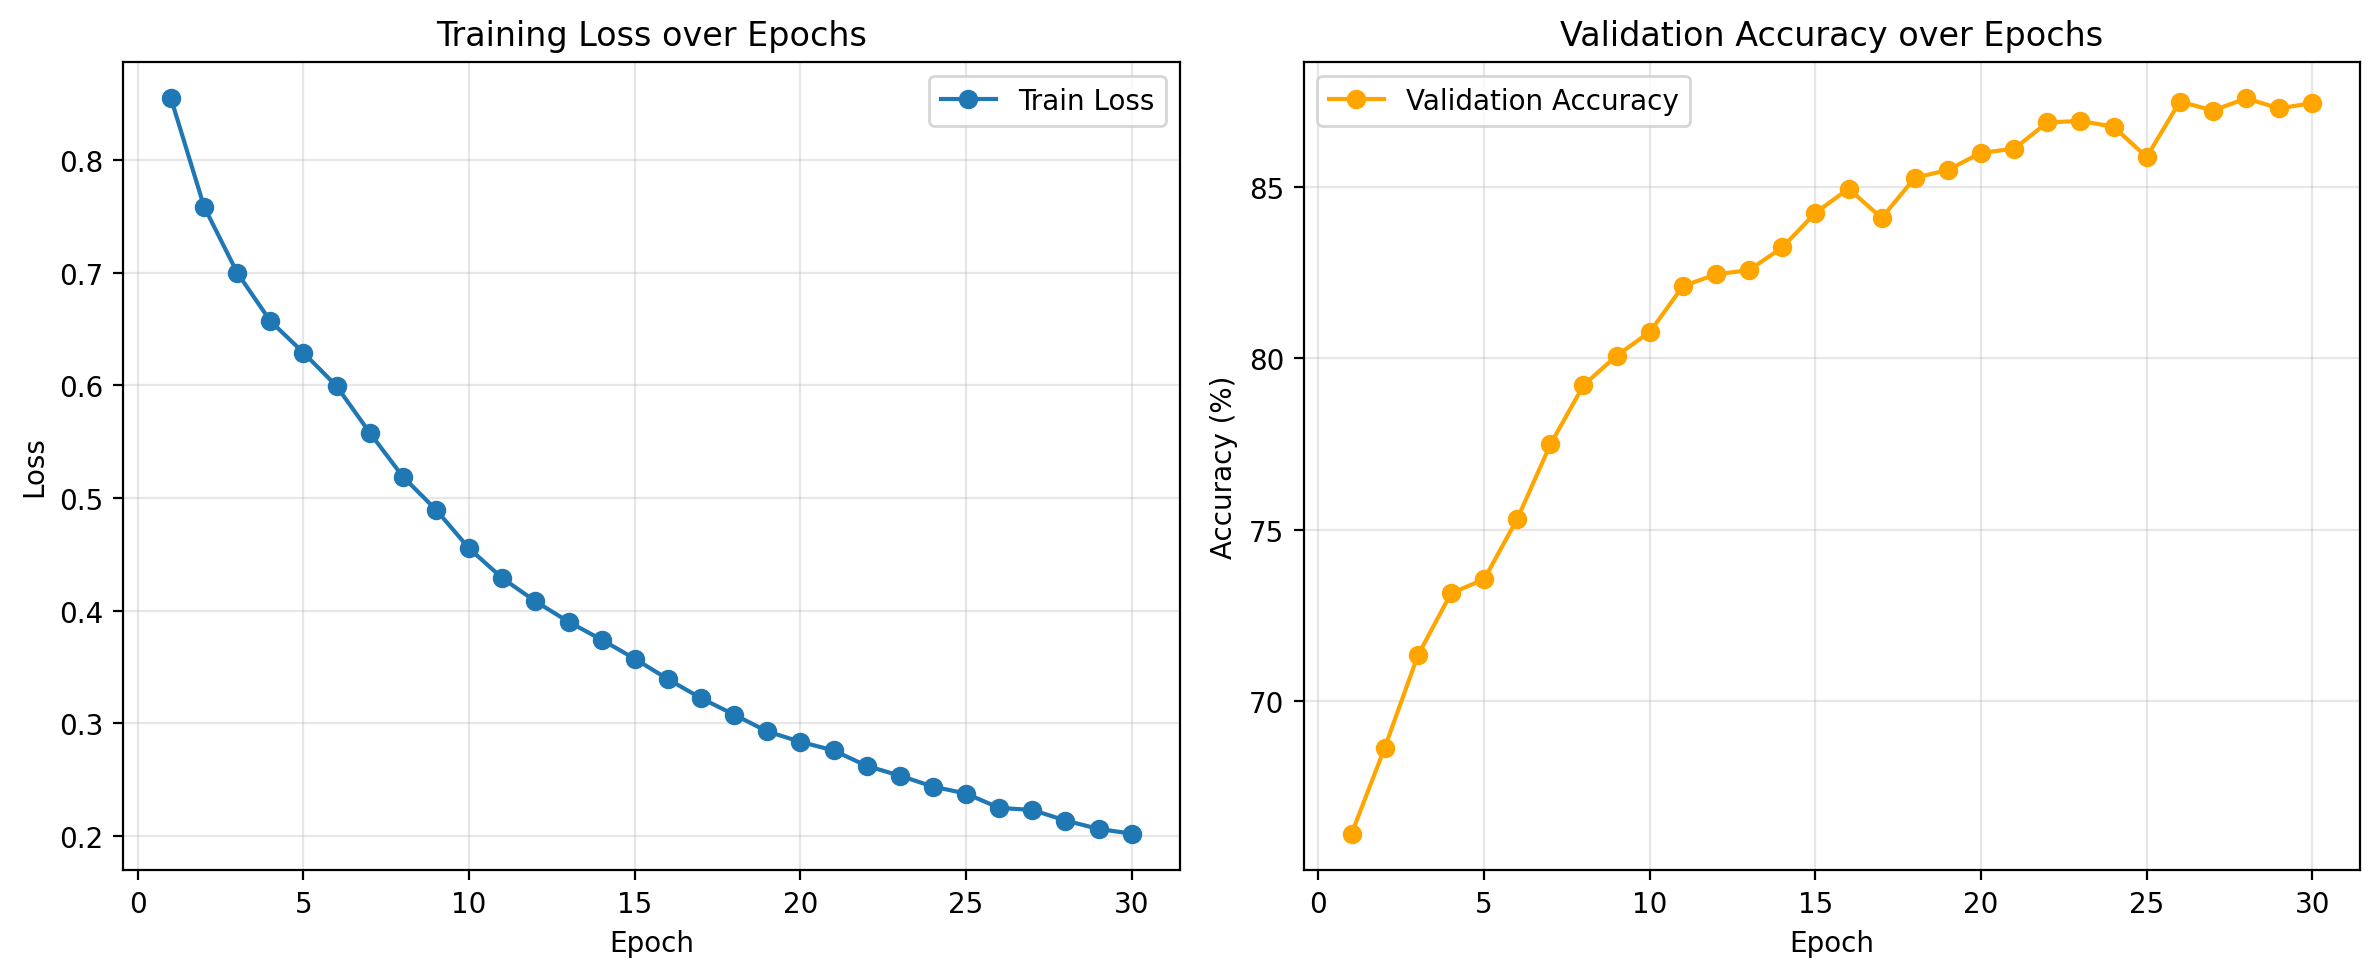

In [29]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True, alpha=0.3)
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, marker='o', color='orange', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy over Epochs')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

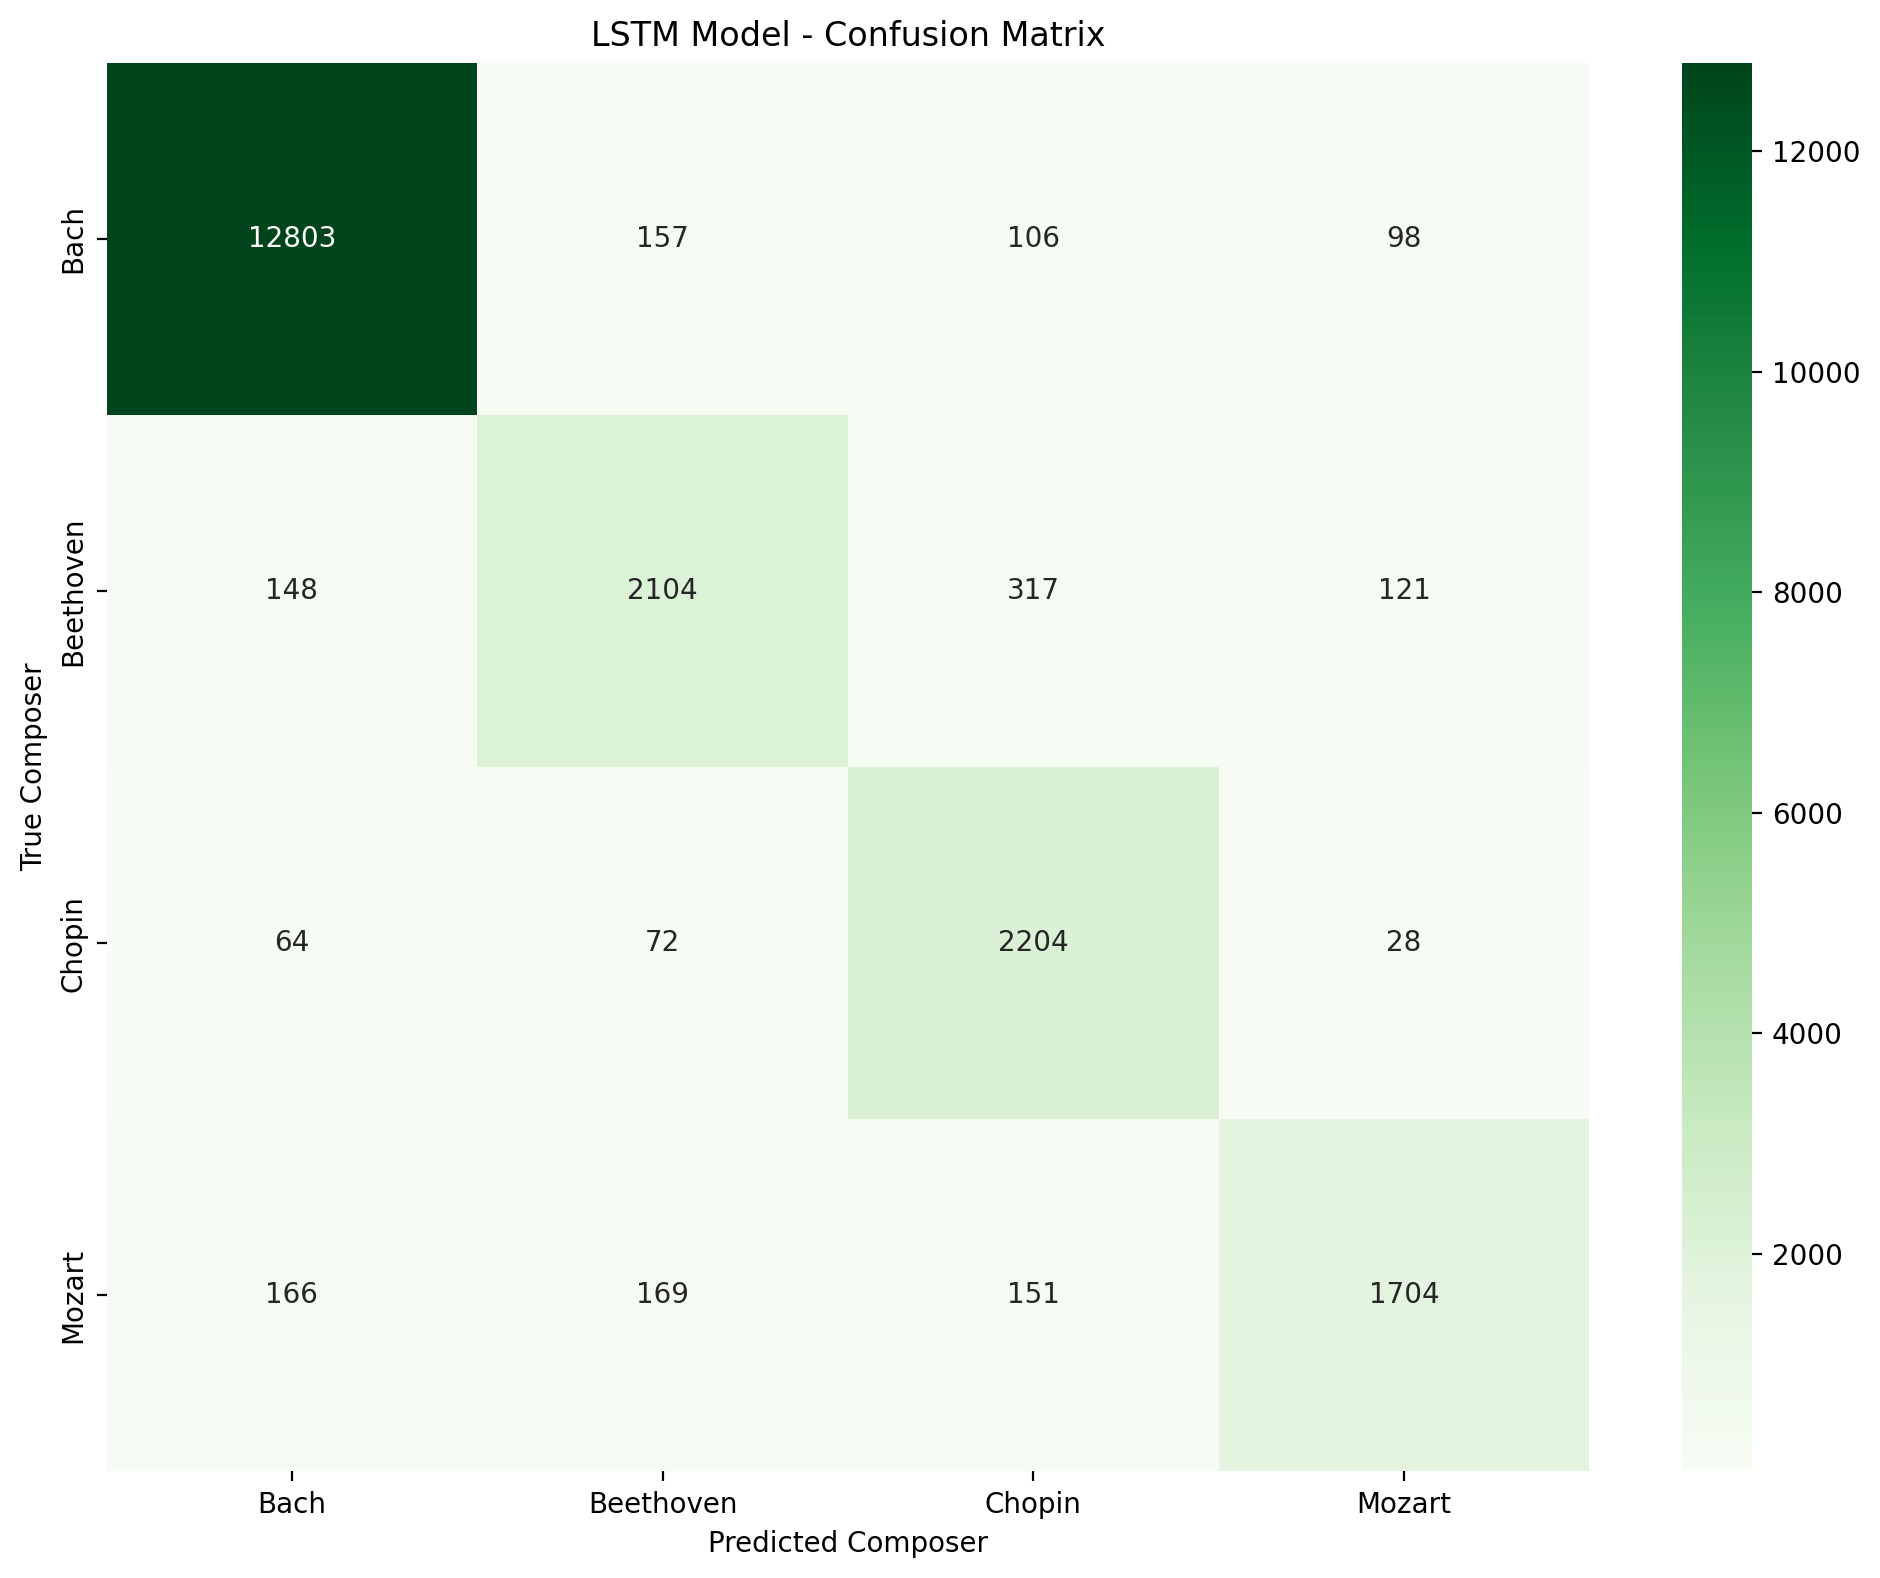

LSTM Classification Report:
              precision    recall  f1-score   support

        Bach       0.97      0.97      0.97     13164
   Beethoven       0.84      0.78      0.81      2690
      Chopin       0.79      0.93      0.86      2368
      Mozart       0.87      0.78      0.82      2190

    accuracy                           0.92     20412
   macro avg       0.87      0.87      0.87     20412
weighted avg       0.92      0.92      0.92     20412



In [30]:
# LSTM Confusion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Recreate LSTM data loaders for confusion matrix (they were deleted during CNN memory cleanup)
with open(os.path.join(OUTPUT_DIR, 'features_lstm.pkl'), 'rb') as f:
    X_lstm = pickle.load(f)
with open(os.path.join(OUTPUT_DIR, 'labels.pkl'), 'rb') as f:
    y_lstm = pickle.load(f)

X_lstm_tensor = torch.tensor(X_lstm, dtype=torch.float32)
y_lstm_tensor = torch.tensor(y_lstm, dtype=torch.long)

dataset_lstm = TensorDataset(X_lstm_tensor, y_lstm_tensor)
train_size = int(0.8 * len(dataset_lstm))
val_size = len(dataset_lstm) - train_size
train_ds_lstm, val_ds_lstm = random_split(dataset_lstm, [train_size, val_size])
val_loader_lstm = DataLoader(val_ds_lstm, batch_size=batch_size, pin_memory=True, num_workers=2)

# Get predictions on validation set for confusion matrix
lstm_model.eval()
y_true_lstm, y_pred_lstm = [], []
with torch.no_grad():
    for X_val, y_val in val_loader_lstm:
        X_val, y_val = X_val.to(DEVICE), y_val.to(DEVICE)
        outputs = lstm_model(X_val)
        _, predicted = torch.max(outputs.data, 1)
        y_true_lstm.extend(y_val.cpu().numpy())
        y_pred_lstm.extend(predicted.cpu().numpy())

# Create confusion matrix
cm_lstm = confusion_matrix(y_true_lstm, y_pred_lstm)
composer_names = [label_to_composer[i] for i in range(len(COMPOSERS))]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens',
            xticklabels=composer_names, yticklabels=composer_names)
plt.title('LSTM Model - Confusion Matrix')
plt.xlabel('Predicted Composer')
plt.ylabel('True Composer')
plt.tight_layout()
plt.show()

# Print classification report
print("LSTM Classification Report:")
print(classification_report(y_true_lstm, y_pred_lstm, target_names=composer_names))

CNN Model training and evaluation

In [31]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

def evaluate_model(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = logits.argmax(1)
            y_true.extend(yb.cpu().numpy())
            y_pred .extend(preds.cpu().numpy())
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    return acc, prec, rec, f1, confusion_matrix(y_true, y_pred)

In [32]:
# Clear CUDA memory before CNN training to prevent out of memory errors
import gc

gc.collect()

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    print(f"CUDA memory cleared. Available memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"Currently allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"Currently cached: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

if 'X_tensor' in locals():
    del X_tensor
if 'y_tensor' in locals():
    del y_tensor
if 'dataset' in locals():
    del dataset
if 'train_ds' in locals():
    del train_ds
if 'val_ds' in locals():
    del val_ds
if 'train_loader' in locals():
    del train_loader
if 'val_loader' in locals():
    del val_loader

# Run garbage collection again after deletions
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"After cleanup - Currently allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

CUDA memory cleared. Available memory: 39.56 GB
Currently allocated: 0.11 GB
Currently cached: 0.45 GB
After cleanup - Currently allocated: 0.11 GB


In [33]:
with open(os.path.join(OUTPUT_DIR, 'features_cnn.pkl'), 'rb') as f:
    Xc = pickle.load(f)  # (N, P, T, 1)
Xc_tensor = torch.tensor(Xc, dtype=torch.float32).permute(0, 3, 1, 2)  # -> (N,1,P,T)
yc_tensor = torch.tensor(labels, dtype=torch.long)

ds_cnn = TensorDataset(Xc_tensor, yc_tensor)
train_size = int(0.8 * len(ds_cnn))
val_size   = len(ds_cnn) - train_size
train_cnn, val_cnn = random_split(ds_cnn, [train_size, val_size])

model_cnn = ComposerCNN(NUM_PITCHES, int(SEGMENT_DURATION_SECONDS * SAMPLES_PER_SECOND)).to(DEVICE)
opt_cnn = optim.Adam(model_cnn.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss().to(DEVICE)

# Initialize lists to store metrics for plotting
cnn_train_losses = []
cnn_val_accuracies = []

cnn_batch_size = 64  # Reduced from 128
train_cnn_loader = DataLoader(train_cnn, batch_size=cnn_batch_size, shuffle=True)
val_cnn_loader = DataLoader(val_cnn, batch_size=cnn_batch_size)

for epoch in range(num_epochs):
    model_cnn.train()
    epoch_train_loss = 0.0
    num_batches = 0

    for batch_idx, (xb, yb) in enumerate(train_cnn_loader):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt_cnn.zero_grad()

        # Use gradient accumulation if memory is still tight
        loss = crit(model_cnn(xb), yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_cnn.parameters(), 1.0)
        opt_cnn.step()

        epoch_train_loss += loss.item()
        num_batches += 1

        # Clear intermediate tensors to save memory
        del xb, yb, loss

        # Clear CUDA cache periodically during training
        if batch_idx % 50 == 0 and torch.cuda.is_available():
            torch.cuda.empty_cache()

    # Calculate average training loss for this epoch
    avg_train_loss = epoch_train_loss / num_batches
    cnn_train_losses.append(avg_train_loss)

    # Evaluate on validation set
    acc, prec, rec, f1, _ = evaluate_model(model_cnn, val_cnn_loader, DEVICE)
    cnn_val_accuracies.append(acc * 100)  # Convert to percentage

    print(f"[CNN] Epoch {epoch+1}: train_loss={avg_train_loss:.4f} acc={acc:.3f} P={prec:.3f} R={rec:.3f} F1={f1:.3f}")

    # Clear cache after each epoch
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Save the CNN model
torch.save(model_cnn.state_dict(), "composer_cnn_model.pth")

# Final memory cleanup
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"Training complete. Final memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

NameError: name 'labels' is not defined

In [ ]:
# Plot CNN Training and Validation Loss/Accuracy
epochs = range(1, len(cnn_train_losses) + 1)

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, cnn_train_losses, marker='o', label='CNN Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN Training Loss over Epochs')
plt.grid(True, alpha=0.3)
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, cnn_val_accuracies, marker='o', color='orange', label='CNN Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('CNN Validation Accuracy over Epochs')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# CNN Confusion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions on validation set for confusion matrix
model_cnn.eval()
y_true_cnn, y_pred_cnn = [], []
with torch.no_grad():
    for xb, yb in val_cnn_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model_cnn(xb)
        preds = logits.argmax(1)
        y_true_cnn.extend(yb.cpu().numpy())
        y_pred_cnn.extend(preds.cpu().numpy())

# Create confusion matrix
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
composer_names = [label_to_composer[i] for i in range(len(COMPOSERS))]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=composer_names, yticklabels=composer_names)
plt.title('CNN Model - Confusion Matrix')
plt.xlabel('Predicted Composer')
plt.ylabel('True Composer')
plt.tight_layout()
plt.show()

# Print classification report
from sklearn.metrics import classification_report
print("CNN Classification Report:")
print(classification_report(y_true_cnn, y_pred_cnn, target_names=composer_names))

In [34]:
class CNNEncoder(nn.Module):
    def __init__(self, out_channels=64):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, out_channels, kernel_size=3, padding=1)
        # pool over pitch only: (2,1) halves pitch, keeps time
        self.pool_pitch = nn.MaxPool2d(kernel_size=(2,1))

    def forward(self, x):
        # x: (N, 1, P, T)
        x = torch.relu(self.conv1(x))
        x = self.pool_pitch(x)             # (N, 32, P/2, T)
        x = torch.relu(self.conv2(x))
        x = self.pool_pitch(x)             # (N, C, P/4, T)
        # global average over remaining pitch bins -> (N, C, 1, T)
        x = x.mean(dim=2, keepdim=True)
        x = x.squeeze(2)                   # (N, C, T)
        x = x.permute(0, 2, 1)             # (N, T, C)
        return x


In [35]:
class FusionLSTM(nn.Module):
    def __init__(self, seq_input_size, cnn_feat_size, hidden_size, num_layers, num_classes, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size=seq_input_size + cnn_feat_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout,
                            bidirectional=False)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, seq_feats, cnn_feats):
        # seq_feats: (N, T, 13), cnn_feats: (N, T, C)
        x = torch.cat([seq_feats, cnn_feats], dim=-1)  # (N, T, 13+C)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

In [36]:
import torch
import gc

# Memory-efficient data loading for fusion model
print("Loading data info...")
features_lstm = None
# First, check if we have batch files or combined files
try:
    with open(os.path.join(OUTPUT_DIR, 'batch_info.pkl'), 'rb') as f:
        batch_info = pickle.load(f)
    use_batch_files = True
    total_samples = batch_info['total_samples']
    total_batches = batch_info['total_batches']
    print(f"Found batch files: {total_batches} batches with {total_samples} total samples")
except FileNotFoundError:
    use_batch_files = False
    print("No batch files found, checking for combined files...")

print(total_samples)
print(use_batch_files)

if use_batch_files:
    # Try loading a small portion to check file sizes
    try:
        print(f"{OUTPUT_DIR}features_lstm.pkl")
        print(f"{OUTPUT_DIR}features_cnn.pkl")
        with open(os.path.join(OUTPUT_DIR, 'features_lstm.pkl'), 'rb') as f:
            features_lstm = pickle.load(f)
        with open(os.path.join(OUTPUT_DIR, 'features_cnn.pkl'), 'rb') as f:
            features_cnn = pickle.load(f)
        with open(os.path.join(OUTPUT_DIR, 'labels.pkl'), 'rb') as f:
            labels = pickle.load(f)

        total_samples = len(features_lstm)
        print(f"Loaded combined files with {total_samples} samples")

        # Check memory usage
        lstm_size_mb = features_lstm.nbytes / (1024*1024)
        cnn_size_mb = features_cnn.nbytes / (1024*1024)
        print(f"Memory usage: LSTM {lstm_size_mb:.1f}MB, CNN {cnn_size_mb:.1f}MB")

        if lstm_size_mb + cnn_size_mb > 2000:  # If larger than 2GB
            print("Files too large for memory, will use subset...")
            # Use only a subset for training
            subset_size = min(5000, len(features_lstm))
            indices = np.random.choice(len(features_lstm), subset_size, replace=False)
            features_lstm = features_lstm[indices]
            features_cnn = features_cnn[indices]
            labels = labels[indices]
            print(f"Using subset of {subset_size} samples")

    except (FileNotFoundError, MemoryError) as e:
        print(f"Error loading combined files: {e}")
        print("Please run the data processing cells first or reduce dataset size")
        raise

# Create tensors from the loaded data
print("Creating tensors...")
X_seq = torch.tensor(features_lstm, dtype=torch.float32)
X_roll = torch.tensor(features_cnn, dtype=torch.float32).permute(0,3,1,2)
y_t = torch.tensor(labels, dtype=torch.long)

# Clear the numpy arrays to save memory
del features_lstm, features_cnn, labels
gc.collect()

# Create dataset
dataset_full = TensorDataset(X_seq, X_roll, y_t)

print(f"Final dataset created:")
print(f"- LSTM features shape: {X_seq.shape}")
print(f"- CNN features shape: {X_roll.shape}")
print(f"- Labels shape: {y_t.shape}")
print(f"- Total samples: {len(dataset_full)}")

# Memory cleanup
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print(f"Memory usage: {X_seq.element_size() * X_seq.nelement() / (1024*1024):.1f}MB + {X_roll.element_size() * X_roll.nelement() / (1024*1024):.1f}MB")

Loading data info...
Found batch files: 33 batches with 102060 total samples
102060
True
./content/processed_data/features_lstm.pkl
./content/processed_data/features_cnn.pkl
Loaded combined files with 102060 samples
Memory usage: LSTM 2530.6MB, CNN 17130.4MB
Files too large for memory, will use subset...
Using subset of 5000 samples
Creating tensors...
Final dataset created:
- LSTM features shape: torch.Size([5000, 500, 13])
- CNN features shape: torch.Size([5000, 1, 88, 500])
- Labels shape: torch.Size([5000])
- Total samples: 5000
Memory usage: 124.0MB + 839.2MB


In [37]:
# Split the dataset into training and validation sets
train_size = int(0.8*len(dataset_full))
train_ds, val_ds = random_split(dataset_full, [train_size, len(dataset_full) - train_size])

In [38]:
# For testing, reduce the size of the training set
#frac = 0.2  # use 20% for quick tests

# Randomly select a subset of the training set
#y_t = y_t[train_ds.indices]  # Get the labels for the training set
#N = len(y_t)
#idx = torch.randperm(N)
#sub_idx = idx[:int(N * frac)]

#dataset_sub  = Subset(dataset_full, sub_idx)

# Split AFTER subsetting (keeps test quick too)
#sub_train_size = int(0.8 * len(dataset_sub))
#train_ds, val_ds = random_split(dataset_sub, [sub_train_size, len(dataset_sub) - sub_train_size])

In [39]:

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, pin_memory=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=64, pin_memory=True, num_workers=2)

In [40]:
cnn_enc = CNNEncoder(out_channels=64).to(DEVICE)
fusion_model   = FusionLSTM(seq_input_size=13, cnn_feat_size=64,
                     hidden_size=128, num_layers=2,
                     num_classes=len(COMPOSERS), dropout=0.3).to(DEVICE)

params = list(cnn_enc.parameters()) + list(fusion_model.parameters())
optimizer = optim.Adam(params, lr=1e-3)
criterion = nn.CrossEntropyLoss().to(DEVICE)


In [41]:
def compute_cls_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    return acc, prec, rec, f1

In [42]:

def evaluate_fusion(cnn_enc, fusion_model, loader, device):
    cnn_enc.eval(); fusion_model.eval()
    y_true, y_pred = [], []
    running_loss = 0.0
    with torch.no_grad():
        for seq_b, roll_b, yb in loader:
            seq_b, roll_b, yb = seq_b.to(device, non_blocking=True), roll_b.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            cnn_feats = cnn_enc(roll_b)           # (N,T,C)
            logits = fusion_model(seq_b, cnn_feats)
            loss = criterion(logits, yb)
            running_loss += loss.item()
            y_true.extend(yb.cpu().numpy())
            y_pred.extend(logits.argmax(1).cpu().numpy())
    acc, prec, rec, f1 = compute_cls_metrics(y_true, y_pred)
    return running_loss / max(1, len(loader)), acc, prec, rec, f1

In [43]:
logger = {"epoch": [], "train_loss": [], "val_loss": [],
          "val_acc": [], "val_prec": [], "val_rec": [], "val_f1": []}

scaler = torch.amp.GradScaler(DEVICE.type)
num_epochs = 20

# Training loop for the fusion model
for epoch in range(num_epochs):
    cnn_enc.train()
    fusion_model.train()
    running = 0.0
    print(f"Epoch {epoch+1}/{num_epochs}")
    for seq_batch, roll_batch, y_batch in train_loader:
        seq_batch = seq_batch.to(DEVICE)          # (N,T,13)
        roll_batch = roll_batch.to(DEVICE)        # (N,1,P,T)
        y_batch = y_batch.to(DEVICE)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(DEVICE.type):
          cnn_feats = cnn_enc(roll_batch)           # (N,T,64)
          logits = fusion_model(seq_batch, cnn_feats)      # (N,num_classes)
          loss = criterion(logits, y_batch)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(params, 1.0)
        scaler.step(optimizer)
        scaler.update()
        running += loss.item()

    # … your existing evaluate_model(val_loader) adapted to take (seq, roll, y) …
    val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate_fusion(cnn_enc, fusion_model, val_loader, DEVICE)
    print(f"Train Loss: {running/len(train_loader):.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Acc: {val_acc:.4f}, "
          f"Val Prec: {val_prec:.4f}, "
          f"Val Rec: {val_rec:.4f}, "
          f"Val F1: {val_f1:.4f}")

    # Log the results
    logger["epoch"].append(epoch+1)
    logger["train_loss"].append(running / max(1, len(train_loader)))
    logger["val_loss"].append(val_loss)
    logger["val_acc"].append(val_acc)
    logger["val_prec"].append(val_prec)
    logger["val_rec"].append(val_rec)
    logger["val_f1"].append(val_f1)

    print(f"Epoch {epoch+1:02d} | train_loss={logger['train_loss'][-1]:.4f} "
          f"| val_loss={val_loss:.4f} | acc={val_acc:.3f} | P={val_prec:.3f} | R={val_rec:.3f} | F1={val_f1:.3f}")

# Save the trained model
torch.save({
    'cnn_encoder_state_dict': cnn_enc.state_dict(),
    'fusion_model_state_dict': fusion_model.state_dict(),
}, 'composer_fusion_model.pth')


Epoch 1/20
Train Loss: 1.0474, Val Loss: 0.9589, Val Acc: 0.6540, Val Prec: 0.1635, Val Rec: 0.2500, Val F1: 0.1977
Epoch 01 | train_loss=1.0474 | val_loss=0.9589 | acc=0.654 | P=0.164 | R=0.250 | F1=0.198
Epoch 2/20
Train Loss: 0.9319, Val Loss: 0.9214, Val Acc: 0.6480, Val Prec: 0.3148, Val Rec: 0.2719, Val F1: 0.2480
Epoch 02 | train_loss=0.9319 | val_loss=0.9214 | acc=0.648 | P=0.315 | R=0.272 | F1=0.248
Epoch 3/20
Train Loss: 0.8605, Val Loss: 0.8944, Val Acc: 0.6570, Val Prec: 0.3892, Val Rec: 0.2990, Val F1: 0.2904
Epoch 03 | train_loss=0.8605 | val_loss=0.8944 | acc=0.657 | P=0.389 | R=0.299 | F1=0.290
Epoch 4/20
Train Loss: 0.7973, Val Loss: 0.8832, Val Acc: 0.6510, Val Prec: 0.3683, Val Rec: 0.3216, Val F1: 0.3111
Epoch 04 | train_loss=0.7973 | val_loss=0.8832 | acc=0.651 | P=0.368 | R=0.322 | F1=0.311
Epoch 5/20
Train Loss: 0.7877, Val Loss: 0.8970, Val Acc: 0.6520, Val Prec: 0.3663, Val Rec: 0.3302, Val F1: 0.3318
Epoch 05 | train_loss=0.7877 | val_loss=0.8970 | acc=0.652 |

Model Evaluation: Evaluate the performance of the deep learning model using accuracy, precision, and recall metrics.


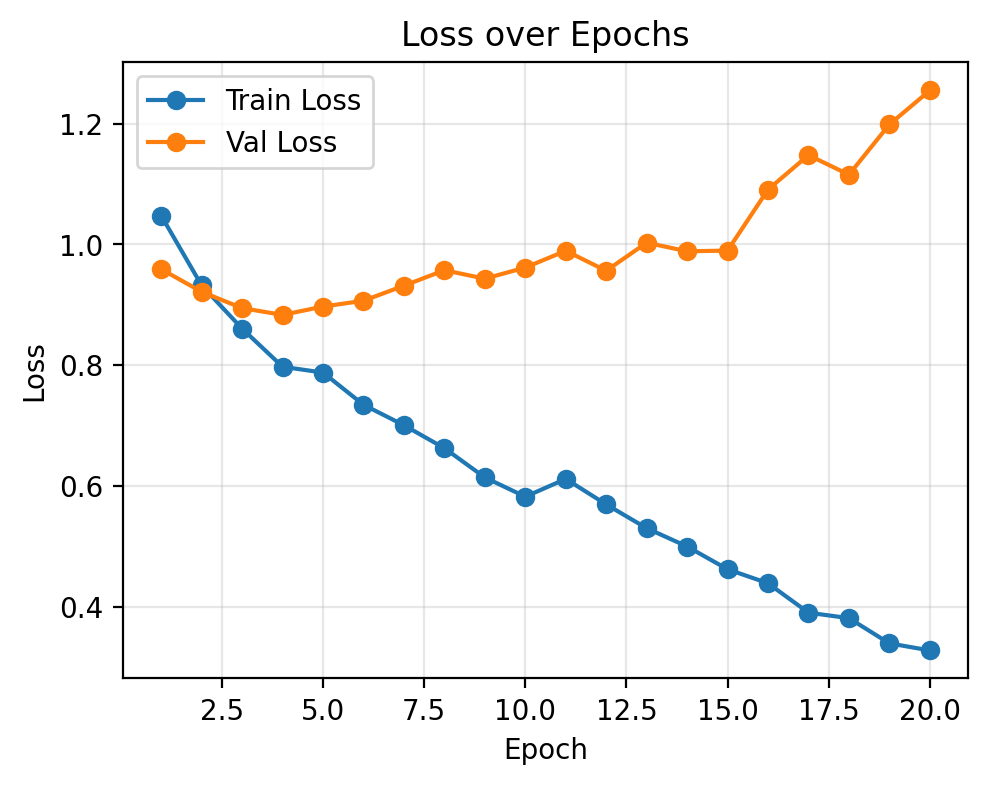

In [44]:
# Plotting the training and validation metrics
epochs = logger["epoch"]

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, logger["train_loss"], marker='o', label='Train Loss')
plt.plot(epochs, logger["val_loss"],   marker='o', label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss over Epochs'); plt.legend(); plt.grid(True, alpha=0.3)


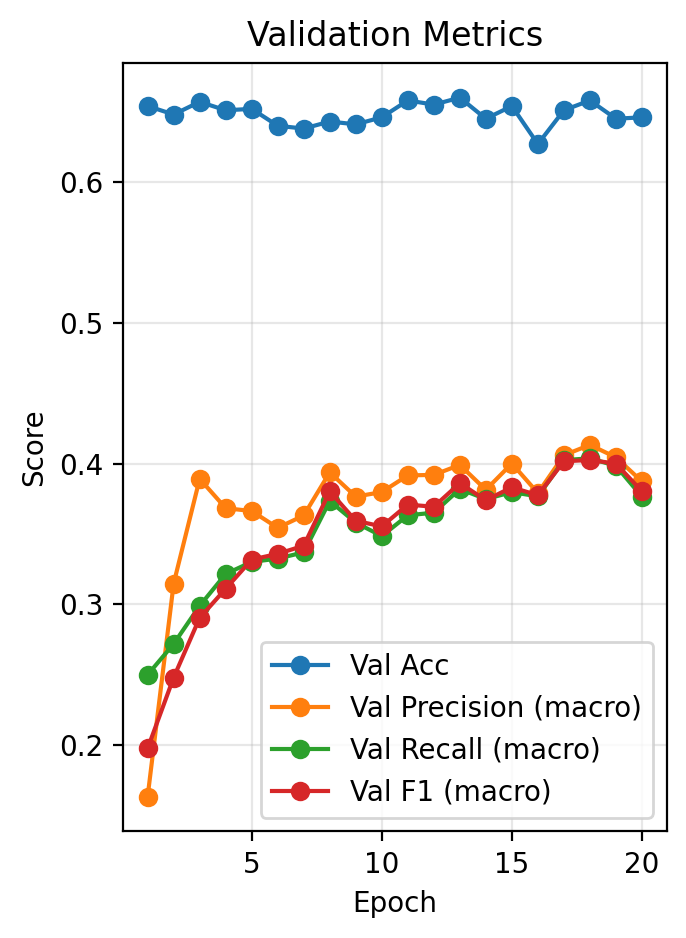

In [45]:

plt.subplot(1,2,2)
plt.plot(epochs, logger["val_acc"],  marker='o', label='Val Acc')
plt.plot(epochs, logger["val_prec"], marker='o', label='Val Precision (macro)')
plt.plot(epochs, logger["val_rec"],  marker='o', label='Val Recall (macro)')
plt.plot(epochs, logger["val_f1"],   marker='o', label='Val F1 (macro)')
plt.xlabel('Epoch'); plt.ylabel('Score'); plt.title('Validation Metrics'); plt.legend(); plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Model Optimization: Optimize the deep learning model by fine-tuning hyperparameters.